# This notebook simulates a simple mountain destroyed by rainfall and glaciers


figured out that scipy zoom really makes the figures shine


## Principles:

* The land starts as rock

* Rain falls on a random set of figures at every step

* Rain flows downhill, and can barely scratch the rock, but drags the gravel along

* The temperature is determined by height

* Rain freezes to glacier if it's below zero

* Glaciers destroy the rock into gravel below them

* Glaciers flow downhill slowly

* When above zero, a glacier melts at a constant rate


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook
import matplotlib as mpl

import scipy.signal as signal
import scipy.ndimage as ndimage
import numba
from numba import jit
import popdyn
import popdyn.convolve as cv
import copy
from importlib import reload
import matplotlib.animation as animation
from IPython.display import HTML

import skimage.transform as sktransform 
from skimage import color, morphology

plt.rcParams["animation.html"] = "jshtml"

# Making a mountainside

In [3]:
def distance_kernel(half_extent=50):
    size = half_extent * 2 + 1
    kernel = np.zeros((size, size))
    vals = np.arange(-half_extent,half_extent+1)
    xx, yy = np.meshgrid(vals, vals, indexing='xy')
    # y, x = np.ogrid[-half_extent:half_extent+1, -half_extent:half_extent+1]
    distance = np.sqrt(xx**2 + yy**2)
    return distance
    
def tophat(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel[dists < radius] = 1
    kernel = kernel / kernel.sum()
    return kernel

def gaussian(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel = np.exp(- dists**2. / (2 * scale**2.))
    kernel = kernel / kernel.sum()
    return kernel

def triangle(dists, scale=50):
    """triangle kernel, scale is when it hits zero"""
    kernel = np.zeros(dists.shape)
    kernel = scale - dists
    kernel[kernel < 0] = 0
    kernel = kernel / kernel.sum()
    return kernel

kernels = {
    "gauss": gaussian,
    "tophat": tophat,
    "triangle": triangle,
}

def make_noise_map(scale, shape, which="gauss"):
    num = shape[0] * shape[1]
    noise = np.random.uniform(size=num).reshape(shape)
    dists = distance_kernel(half_extent=scale*3)
    
    
    kern = kernels[which](dists, scale=scale)
    tmp = np.fft.irfft2(np.fft.rfft2(noise) * np.fft.rfft2(kern, noise.shape))
    tmp = tmp - tmp.min()
    tmp = tmp / tmp.max()
    
    return tmp

def convolve_map(canvas, scale, which = "gauss",):
    pad_width = scale*3
    padded = np.pad(canvas, pad_width = scale*3)
    half_extent = scale*2
    dists = distance_kernel(half_extent = half_extent)    
    kern = kernels[which](dists, scale = scale)
    
    # There's some shape difference here, which needs to be manually corrected with the padding
    # just offset the convolved image by the half_extent of the kernel...
    tmp = np.fft.irfft2(np.fft.rfft2(padded) * np.fft.rfft2(kern, padded.shape))
    tmp = tmp[pad_width+half_extent:-pad_width+half_extent, pad_width+half_extent:-pad_width+half_extent]
    return tmp

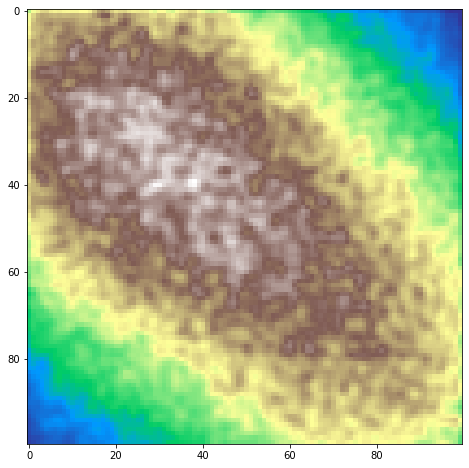

In [4]:
samples1 = np.random.multivariate_normal((1.7, 1.8), cov=np.eye(2), size=int(2.e6))
samples2 = np.random.multivariate_normal((0.4, 0.3), cov=np.eye(2), size=int(2.4e6))
# samples2 = np.random.multivariate_normal((3., 4.), cov=np.eye(2)*1, size=1800000)
# samples3 = np.random.multivariate_normal((4.5, 1.8), cov=np.eye(2), size=1100000)
# samples4 = np.random.multivariate_normal((7, 3), cov=np.eye(2)*1.5, size=2000000)
samples = np.concatenate((samples1, samples2))

bins = np.linspace(0, 2, 104)

bcens = bins[:-1] + np.diff(bins) / 2
land = np.histogram2d(samples[:, 0], samples[:, 1], bins=(bins, bins), density=True)[0] * 4
land = convolve_map(land, 1, which="gauss")
land = land[1:-2, 1:-1]

lmax = land.max()
land = (land / lmax)**2. * lmax
land *= 5000

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.imshow(land, cmap=plt.cm.terrain)

In [5]:
zland = ndimage.zoom(land, 2)

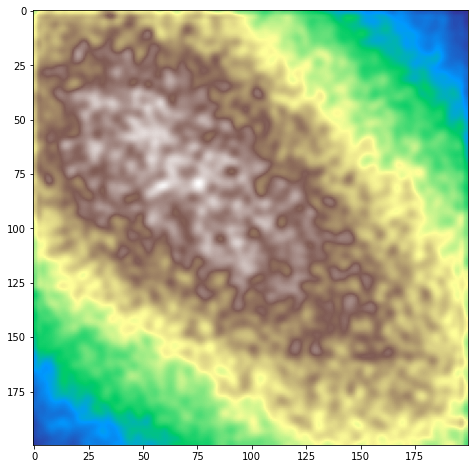

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.imshow(zland, cmap=plt.cm.terrain)

In [7]:
land.min()

694.5815785940288

# Erosion model of the mountain side

In [8]:
def calc_shifted(inmap):
    """shift up, down, left, right"""

    omap = []
    tmp = np.roll(inmap, -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    tmp = np.roll(inmap, 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     
    return np.array(omap)   

def calc_unshifted(inmap):
    omap = []

    tmp = np.roll(inmap[0, :, :], 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[1, :, :], -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[2, :, :], 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     

    tmp = np.roll(inmap[3, :, :], -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    return np.array(omap)

def center_cut(arr):
    return arr[1:-1, 1:-1]

def null_edges(arr):
    arr[0, :] = 0.
    arr[:, 0] = 0.
    arr[:, -1] = 0.
    arr[-1, :] = 0.
    return arr

In [9]:
def pad(canvases):
    """padsfor each canvas pad the 2d array"""
    keys = canvases.keys()
    padded_canvases = {}
    for key in keys:
        arr = canvases[key]
        arr = np.pad(arr, pad_width=1, mode="edge")
        padded_canvases.update({key: arr})
    return padded_canvases

class CellSpace(object):
    def __init__(self, initial_maps, rules):
        """
        Cell automata, considers the direct neighbor cells only
        
        Initialize with a dict of initial maps in the style
        
        initial_maps = {
            "layer_name": initial map,
        }
        
        The rules are a similar dictionary of class instances which will be passed 
        
        
        """
        self.canvases = copy.deepcopy(initial_maps)
        self.layers = list(initial_maps.keys())
        self.padded_canvases = pad(self.canvases)

        self.shape_canvas = self.canvases[self.layers[0]].shape
        self.shape_canvas_padded = self.padded_canvases[self.layers[0]].shape
    
        self.imap = np.arange(len(self.canvases[self.layers[0]].flatten())).reshape(self.shape_canvas)
        self.imap_padded = np.arange(len(self.padded_canvases[self.layers[0]].flatten())).reshape(self.shape_canvas_padded)
        self.imap_center = center_cut(self.imap_padded)
        self.imap_shifted = [center_cut(tmp) for tmp in calc_shifted(self.imap_padded)]
        self.imap_unshifted = [
            self.imap_shifted[1],
            self.imap_shifted[0],
            self.imap_shifted[3],
            self.imap_shifted[2],
        ]
        
        self.shifted_canvases = self.shift()
        self.rules = rules
        
        self.maps = {}
        self.reset_maps()
            
    def update_maps(self):
        for key in self.layers:
            self.maps[key].append(self.canvases[key].copy())
            
    def reset_maps(self):
        self.maps = {}
        for key in self.layers:
#             dd = {key: [self.canvases[key],]}
            dd = {key: []}
            self.maps.update(dd)            
       
    def shift(self):
        shifted_canvases = {}
        for key in self.canvases.keys():
            arr = np.array([self.padded_canvases[key].flat[ii] for ii in self.imap_shifted])
            shifted_canvases.update({key: arr})
        return shifted_canvases
            
            
    def step(self):
        
        new_canvases = {}
        for rule in self.rules:
            canvas = rule.evolve(self)
            new_canvases.update(canvas)
            
        self.canvases = new_canvases
        self.padded_canvases = pad(self.canvases)
        self.shifted_canvases = self.shift()


    def flow(self, nstep=100, savestep=5):
        """
        a series of steps
        """
        self.reset_maps()
        self.update_maps()
        for i in np.arange(nstep):
#             print(str(i) + ' out of ' + str(nstep-1), end="\r")
            print(str(i) + ' out of ' + str(nstep-1), end="\n")
            self.step()
            if i % savestep == 0:
                self.update_maps()

In [20]:
class FlowRule(object):
    def __init__(self, flow_factor=0.5):
        """
        The way this automata is set up is with a walled boundary condition, matter can flow to the edges, but not out of it
        Therefore matter is conserved in the canvas. That's good
        
        An erosion factor of 1 makes a really unstable checkerboard behaviour, use smaller values for a balanced behaviour,
        """
        self.layers = np.sort(("terrain",))
        self.key = "terrain"
#         self.needed_keys ["terrain",]
        if flow_factor >= 1:
            raise ValueError("flow_factor must be less than 1, current value is {:.3f}".format(flow_factor))
        self.flow_factor = flow_factor
        
    def evolve(self, cell):
        height_local = cell.canvases[self.key]
        height_shifted = cell.shifted_canvases[self.key]
        
        diffs = height_local - height_shifted
#         diffs[diffs < 0] = 0
        diffs[diffs < diffs.max(axis=0)] = 0. 
#         fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        
        outflow = diffs * self.flow_factor # this is the outgoing amount
#         print(outflow)
        height_local = self.calc_flows(height_local, outflow, cell)
        resdict = cell.canvases
        resdict.update({self.key: height_local})
        return resdict

    def _calc_flows(self, vmap, outflow, cell):
        shifted_landslide = [] 
        for i, ii in enumerate(cell.imap_unshifted):
            # the padding here is what restricts the landslide to the frozen boundary condition
            tmp = np.pad(outflow[i], pad_width=1, mode="constant", constant_values=0)
            tmp = tmp.flat[ii]
            shifted_landslide.append(tmp)
        shifted_landslide = np.array(shifted_landslide)
        return shifted_landslide.sum(axis=0)
    
    def calc_flows(self, vmap, outflow, cell):
        vmap -= outflow.sum(axis=0)
        vmap += self._calc_flows(vmap, outflow, cell)
        return vmap
         
        
class RainFall(FlowRule):
    def __init__(self, rainfall=1, fraction=0.2, seed=10):
        """
        This is adds new rain water to the water canvas
    
        """
        self.layers = np.sort(("water",))
        self.key = "water"
        self.rainfall = rainfall
        self.fraction = fraction
        self.rng = np.random.RandomState(seed)
        
    def evolve(self,  cell):
        water_local = cell.canvases[self.key]
        
        rmax = 100
        rpiv = rmax * (1 - self.fraction)
        rainmap = np.random.random(size=water_local.shape) * rmax
        rainmap[rainmap <= rpiv] = 0.
        rainmap[rainmap > rpiv] = self.rainfall
        
        water_local += rainmap
        
        resdict = cell.canvases
        resdict.update({self.key: water_local})
        return resdict               
        


In [25]:
arr = np.linspace(0, 5000, 100)

In [54]:
def temperature(vals):
    res = (2000 - vals) / 100 
    return res

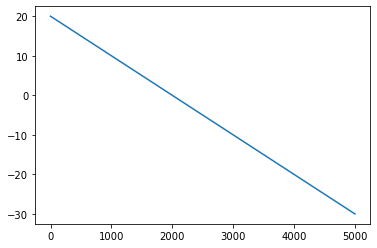

In [55]:
plt.plot(arr, temperature(arr))

In [56]:
   
class IceWaterGravelFlow(FlowRule):
    def __init__(self, altitude=10000, water_flow_rate=0.5, land_coerosion_rate=0.1,
                 drag_coeff=0.1, gravel_factor=4, flow_limit=10.,
                 ice_fracturing_rate=0.1, ice_melt_rate=0.05, ice_melt_min=10, ice_flow_rate=0.05,
                 temperature0=20, temperature_2k=0,
                ):
        """
        This is a four component erosion model with glaciers
        
        This is a three component erosion model where water flows fast, and drags a fraction of the land with it
        Any land once dragged, will becone gravel, which erodes very easily
        
        wflow_rate is the water flaw per time step
        lflow rate is the land coerosion per time step, this should be much smaller than the water flow rate
        gravel_factor is the multiplier to the land coerosion rate
        
        The local gradient step is determined by the total land plus water height,
        and each component is dragged separately
        
        this is the lazy river approximation, where the velocity of water is negligible. Perhaps this is a mistake
        
        """
        self.layers = np.sort(("rock", "gravel" , "water", "ice"))
        self.wkey = "water"
        self.lkey = "rock"
        self.gkey = "gravel"
        self.ikey = "ice"
        self.water_flow_rate = water_flow_rate
        self.land_coerosion_rate = land_coerosion_rate
        self.drag_coeff = drag_coeff
        self.gravel_factor = gravel_factor
        self.ice_fracturing_rate = ice_fracturing_rate
        self.ice_melt_rate = ice_melt_rate
        self.ice_melt_min = ice_melt_min
        self.ice_flow_rate = ice_flow_rate
        self.altitude = altitude
        
        self.temperature0 = temperature0
        self.temperature_2k = temperature_2k
        
    def get_temperature_map(self, height_local):
        res = (h2k - vals) / (self.temperature_2k / self.temperature0)
        return tmp
    
    
    
    def freezing(self, ice, temp, water):
        """
        This is actually melting and freezing melting is negative freezing
        
        Ice has some time to melt, and to freeze,
        this is a self similar proportional process, with a minimum cutoff step
        """
        
        meltwater = np.zeros(ice,shape)
        newice = np.zeros(ice,shape)
        
        imelt = np.where(temp > 0)
        ifreeze = np.where(temp <= 0)
        
        meltwater[imelt] = ice[imelt] * self.ice_melt_rate
        ii = np.where(meltwater[imelt] < self.ice_melt_min)
        meltwater[imelt][ii] = self.ice_melt_min
        
        newice[ifreeye] = water[ifreeze] * ice_melt_rate
        ii = np.where(meltwater[imelt] < self.ice_melt_min)
        meltwater[imelt][ii] = self.ice_melt_min        
        
        
#         meltwater = np.max(((ice[imelt] * ice_melt_rate), (np.ones(ice[imelt].shape) * self.ice_melt_min), axis=2) 
#         imelt = np.where(temp > 0)
        
        
                
    def evolve(self, cell):
        """
        It is interesting that the outflow direction is set by land + gravel,
        but the amount of drag possible is two
        """
#         np.set_printoptions(suppress=True)

        # these are the only canvases we are going to care about at all
        rock_local = cell.canvases[self.lkey]
        rock_shifted = cell.shifted_canvases[self.lkey]
        
        gravel_local = cell.canvases[self.gkey]
        gravel_shifted = cell.shifted_canvases[self.gkey]
        
        water_local = cell.canvases[self.wkey]
        water_shifted = cell.shifted_canvases[self.wkey]
        
        ice_local = cell.canvases[self.ikey]
        ice_shifted = cell.shifted_canvases[self.ikey]
        
        height_local = rock_local + gravel_local + water_local
        height_shifted = rock_shifted + gravel_shifted + water_shifted
        
        temp_local = self.get_temperature_map(height_local) # temperature is static, it matter locally only

        # 1) water freezes at a steady rate
        ice_local = 
        
        # 1) water flows along the gradient
        diffs = height_local - height_shifted
        diffs[diffs < 0] = 0
        fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        outflow_w = water_local * fractions * self.water_flow_rate
        water_local = self.calc_flows(water_local, outflow_w, cell)
        water_local = null_edges(water_local) # This models the part where water flows out of the canvas
        # no more land can outflow than there is difference
        # Due to the megaoutflow approximation, the water height can be VERY high, this means we need to rationalize
        # The amount of land drag possible to an actual sensible maximum
        
        # The rock must only eroded if there is no more gravel left... This is a really curious nonlinearity
        
        # 2) the gravel flows
        gflow_limit = np.sqrt(gravel_local) * self.drag_coeff * self.gravel_factor
        ii = np.where(gflow_limit > 0.1 * gravel_local)
        gflow_limit[ii] = 0.1 * gravel_local[ii]        
        gflow_limit = np.array([gflow_limit, ] * 4) / 4.
        outflow_g = outflow_w * self.land_coerosion_rate * self.gravel_factor
        ii = outflow_g > (gflow_limit)
        outflow_g[ii] = gflow_limit[ii]        
        gravel_local = self.calc_flows(gravel_local, outflow_g, cell)

        
        # 3) The rock erodes
        # we have to establish the local gravel coverage
        # The rock is eroded by the flow of water
        lflow_limit = np.sqrt(rock_local) * self.drag_coeff
        ii = np.where(lflow_limit > 0.1 * rock_local)
        lflow_limit[ii] = 0.1 * rock_local[ii]
        ii = np.where(gravel_local > 0)
        lflow_limit[ii] = 0. # This means the rock will never erode if its covered by gravel
        lflow_limit = np.array([lflow_limit, ] * 4) / 4.
#         lflow_limit = np.array([rock_local * self.drag_coeff,] * 4) / 4 # limit how much land can be dragged at each point
        
        # in megaoutflow, water can pile up really high, this must be regularized
        outflow_l = outflow_w * self.land_coerosion_rate
        ii = outflow_l > (lflow_limit)
        outflow_l[ii] = lflow_limit[ii]        
        
        rock_local -= outflow_l.sum(axis=0)    
        # The land is flown into gravel, not into land
        
        # 4) the gravel flows again to receive the erosion of the rock
        gravel_local += self._calc_flows(gravel_local, outflow_l, cell)

        resdict = cell.canvases
        resdict.update({self.wkey: water_local, self.lkey: rock_local, self.gkey: gravel_local})
        
#         np.set_printoptions(suppress=False)
        return resdict    


In [22]:
rules = (
    RainFall(rainfall=0.1, fraction=0.2),
    WaterGravelFlow(land_coerosion_rate=0.05, water_flow_rate=0.9, drag_coeff=4, gravel_factor=10),
)
wmap = np.zeros(shape=zland.shape)
gmap = np.zeros(shape=zland.shape)
initial_maps = {
    "rock": null_edges(zland * 0.8),
    "gravel": null_edges(zland * 0.2),
    "water": null_edges(wmap),
}

In [82]:
cs = CellSpace(initial_maps, rules)
cs.flow(8000, savestep=200)

all_rock = copy.deepcopy(cs.maps["rock"])
all_gravel = copy.deepcopy(cs.maps["gravel"])
all_waters = copy.deepcopy(cs.maps["water"])

0 out of 7999
1 out of 7999
2 out of 7999
3 out of 7999
4 out of 7999
5 out of 7999
6 out of 7999
7 out of 7999
8 out of 7999
9 out of 7999
10 out of 7999
11 out of 7999
12 out of 7999
13 out of 7999
14 out of 7999
15 out of 7999
16 out of 7999
17 out of 7999
18 out of 7999
19 out of 7999
20 out of 7999
21 out of 7999


/tmp/ipykernel_5482/625500427.py:51: RuntimeWarning: invalid value encountered in true_divide
  fractions = np.nan_to_num(diffs / diffs.sum(axis=0))


22 out of 7999
23 out of 7999
24 out of 7999
25 out of 7999
26 out of 7999
27 out of 7999
28 out of 7999
29 out of 7999
30 out of 7999
31 out of 7999
32 out of 7999
33 out of 7999
34 out of 7999
35 out of 7999
36 out of 7999
37 out of 7999
38 out of 7999
39 out of 7999
40 out of 7999
41 out of 7999
42 out of 7999
43 out of 7999
44 out of 7999
45 out of 7999
46 out of 7999
47 out of 7999
48 out of 7999
49 out of 7999
50 out of 7999
51 out of 7999
52 out of 7999
53 out of 7999
54 out of 7999
55 out of 7999
56 out of 7999
57 out of 7999
58 out of 7999
59 out of 7999
60 out of 7999
61 out of 7999
62 out of 7999
63 out of 7999
64 out of 7999
65 out of 7999
66 out of 7999
67 out of 7999
68 out of 7999
69 out of 7999
70 out of 7999
71 out of 7999
72 out of 7999
73 out of 7999
74 out of 7999
75 out of 7999
76 out of 7999
77 out of 7999
78 out of 7999
79 out of 7999
80 out of 7999
81 out of 7999
82 out of 7999
83 out of 7999
84 out of 7999
85 out of 7999
86 out of 7999
87 out of 7999
88 out of 

560 out of 7999
561 out of 7999
562 out of 7999
563 out of 7999
564 out of 7999
565 out of 7999
566 out of 7999
567 out of 7999
568 out of 7999
569 out of 7999
570 out of 7999
571 out of 7999
572 out of 7999
573 out of 7999
574 out of 7999
575 out of 7999
576 out of 7999
577 out of 7999
578 out of 7999
579 out of 7999
580 out of 7999
581 out of 7999
582 out of 7999
583 out of 7999
584 out of 7999
585 out of 7999
586 out of 7999
587 out of 7999
588 out of 7999
589 out of 7999
590 out of 7999
591 out of 7999
592 out of 7999
593 out of 7999
594 out of 7999
595 out of 7999
596 out of 7999
597 out of 7999
598 out of 7999
599 out of 7999
600 out of 7999
601 out of 7999
602 out of 7999
603 out of 7999
604 out of 7999
605 out of 7999
606 out of 7999
607 out of 7999
608 out of 7999
609 out of 7999
610 out of 7999
611 out of 7999
612 out of 7999
613 out of 7999
614 out of 7999
615 out of 7999
616 out of 7999
617 out of 7999
618 out of 7999
619 out of 7999
620 out of 7999
621 out of 7999
622 out 

1070 out of 7999
1071 out of 7999
1072 out of 7999
1073 out of 7999
1074 out of 7999
1075 out of 7999
1076 out of 7999
1077 out of 7999
1078 out of 7999
1079 out of 7999
1080 out of 7999
1081 out of 7999
1082 out of 7999
1083 out of 7999
1084 out of 7999
1085 out of 7999
1086 out of 7999
1087 out of 7999
1088 out of 7999
1089 out of 7999
1090 out of 7999
1091 out of 7999
1092 out of 7999
1093 out of 7999
1094 out of 7999
1095 out of 7999
1096 out of 7999
1097 out of 7999
1098 out of 7999
1099 out of 7999
1100 out of 7999
1101 out of 7999
1102 out of 7999
1103 out of 7999
1104 out of 7999
1105 out of 7999
1106 out of 7999
1107 out of 7999
1108 out of 7999
1109 out of 7999
1110 out of 7999
1111 out of 7999
1112 out of 7999
1113 out of 7999
1114 out of 7999
1115 out of 7999
1116 out of 7999
1117 out of 7999
1118 out of 7999
1119 out of 7999
1120 out of 7999
1121 out of 7999
1122 out of 7999
1123 out of 7999
1124 out of 7999
1125 out of 7999
1126 out of 7999
1127 out of 7999
1128 out of 79

1556 out of 7999
1557 out of 7999
1558 out of 7999
1559 out of 7999
1560 out of 7999
1561 out of 7999
1562 out of 7999
1563 out of 7999
1564 out of 7999
1565 out of 7999
1566 out of 7999
1567 out of 7999
1568 out of 7999
1569 out of 7999
1570 out of 7999
1571 out of 7999
1572 out of 7999
1573 out of 7999
1574 out of 7999
1575 out of 7999
1576 out of 7999
1577 out of 7999
1578 out of 7999
1579 out of 7999
1580 out of 7999
1581 out of 7999
1582 out of 7999
1583 out of 7999
1584 out of 7999
1585 out of 7999
1586 out of 7999
1587 out of 7999
1588 out of 7999
1589 out of 7999
1590 out of 7999
1591 out of 7999
1592 out of 7999
1593 out of 7999
1594 out of 7999
1595 out of 7999
1596 out of 7999
1597 out of 7999
1598 out of 7999
1599 out of 7999
1600 out of 7999
1601 out of 7999
1602 out of 7999
1603 out of 7999
1604 out of 7999
1605 out of 7999
1606 out of 7999
1607 out of 7999
1608 out of 7999
1609 out of 7999
1610 out of 7999
1611 out of 7999
1612 out of 7999
1613 out of 7999
1614 out of 79

2040 out of 7999
2041 out of 7999
2042 out of 7999
2043 out of 7999
2044 out of 7999
2045 out of 7999
2046 out of 7999
2047 out of 7999
2048 out of 7999
2049 out of 7999
2050 out of 7999
2051 out of 7999
2052 out of 7999
2053 out of 7999
2054 out of 7999
2055 out of 7999
2056 out of 7999
2057 out of 7999
2058 out of 7999
2059 out of 7999
2060 out of 7999
2061 out of 7999
2062 out of 7999
2063 out of 7999
2064 out of 7999
2065 out of 7999
2066 out of 7999
2067 out of 7999
2068 out of 7999
2069 out of 7999
2070 out of 7999
2071 out of 7999
2072 out of 7999
2073 out of 7999
2074 out of 7999
2075 out of 7999
2076 out of 7999
2077 out of 7999
2078 out of 7999
2079 out of 7999
2080 out of 7999
2081 out of 7999
2082 out of 7999
2083 out of 7999
2084 out of 7999
2085 out of 7999
2086 out of 7999
2087 out of 7999
2088 out of 7999
2089 out of 7999
2090 out of 7999
2091 out of 7999
2092 out of 7999
2093 out of 7999
2094 out of 7999
2095 out of 7999
2096 out of 7999
2097 out of 7999
2098 out of 79

2527 out of 7999
2528 out of 7999
2529 out of 7999
2530 out of 7999
2531 out of 7999
2532 out of 7999
2533 out of 7999
2534 out of 7999
2535 out of 7999
2536 out of 7999
2537 out of 7999
2538 out of 7999
2539 out of 7999
2540 out of 7999
2541 out of 7999
2542 out of 7999
2543 out of 7999
2544 out of 7999
2545 out of 7999
2546 out of 7999
2547 out of 7999
2548 out of 7999
2549 out of 7999
2550 out of 7999
2551 out of 7999
2552 out of 7999
2553 out of 7999
2554 out of 7999
2555 out of 7999
2556 out of 7999
2557 out of 7999
2558 out of 7999
2559 out of 7999
2560 out of 7999
2561 out of 7999
2562 out of 7999
2563 out of 7999
2564 out of 7999
2565 out of 7999
2566 out of 7999
2567 out of 7999
2568 out of 7999
2569 out of 7999
2570 out of 7999
2571 out of 7999
2572 out of 7999
2573 out of 7999
2574 out of 7999
2575 out of 7999
2576 out of 7999
2577 out of 7999
2578 out of 7999
2579 out of 7999
2580 out of 7999
2581 out of 7999
2582 out of 7999
2583 out of 7999
2584 out of 7999
2585 out of 79

3015 out of 7999
3016 out of 7999
3017 out of 7999
3018 out of 7999
3019 out of 7999
3020 out of 7999
3021 out of 7999
3022 out of 7999
3023 out of 7999
3024 out of 7999
3025 out of 7999
3026 out of 7999
3027 out of 7999
3028 out of 7999
3029 out of 7999
3030 out of 7999
3031 out of 7999
3032 out of 7999
3033 out of 7999
3034 out of 7999
3035 out of 7999
3036 out of 7999
3037 out of 7999
3038 out of 7999
3039 out of 7999
3040 out of 7999
3041 out of 7999
3042 out of 7999
3043 out of 7999
3044 out of 7999
3045 out of 7999
3046 out of 7999
3047 out of 7999
3048 out of 7999
3049 out of 7999
3050 out of 7999
3051 out of 7999
3052 out of 7999
3053 out of 7999
3054 out of 7999
3055 out of 7999
3056 out of 7999
3057 out of 7999
3058 out of 7999
3059 out of 7999
3060 out of 7999
3061 out of 7999
3062 out of 7999
3063 out of 7999
3064 out of 7999
3065 out of 7999
3066 out of 7999
3067 out of 7999
3068 out of 7999
3069 out of 7999
3070 out of 7999
3071 out of 7999
3072 out of 7999
3073 out of 79

3499 out of 7999
3500 out of 7999
3501 out of 7999
3502 out of 7999
3503 out of 7999
3504 out of 7999
3505 out of 7999
3506 out of 7999
3507 out of 7999
3508 out of 7999
3509 out of 7999
3510 out of 7999
3511 out of 7999
3512 out of 7999
3513 out of 7999
3514 out of 7999
3515 out of 7999
3516 out of 7999
3517 out of 7999
3518 out of 7999
3519 out of 7999
3520 out of 7999
3521 out of 7999
3522 out of 7999
3523 out of 7999
3524 out of 7999
3525 out of 7999
3526 out of 7999
3527 out of 7999
3528 out of 7999
3529 out of 7999
3530 out of 7999
3531 out of 7999
3532 out of 7999
3533 out of 7999
3534 out of 7999
3535 out of 7999
3536 out of 7999
3537 out of 7999
3538 out of 7999
3539 out of 7999
3540 out of 7999
3541 out of 7999
3542 out of 7999
3543 out of 7999
3544 out of 7999
3545 out of 7999
3546 out of 7999
3547 out of 7999
3548 out of 7999
3549 out of 7999
3550 out of 7999
3551 out of 7999
3552 out of 7999
3553 out of 7999
3554 out of 7999
3555 out of 7999
3556 out of 7999
3557 out of 79

3983 out of 7999
3984 out of 7999
3985 out of 7999
3986 out of 7999
3987 out of 7999
3988 out of 7999
3989 out of 7999
3990 out of 7999
3991 out of 7999
3992 out of 7999
3993 out of 7999
3994 out of 7999
3995 out of 7999
3996 out of 7999
3997 out of 7999
3998 out of 7999
3999 out of 7999
4000 out of 7999
4001 out of 7999
4002 out of 7999
4003 out of 7999
4004 out of 7999
4005 out of 7999
4006 out of 7999
4007 out of 7999
4008 out of 7999
4009 out of 7999
4010 out of 7999
4011 out of 7999
4012 out of 7999
4013 out of 7999
4014 out of 7999
4015 out of 7999
4016 out of 7999
4017 out of 7999
4018 out of 7999
4019 out of 7999
4020 out of 7999
4021 out of 7999
4022 out of 7999
4023 out of 7999
4024 out of 7999
4025 out of 7999
4026 out of 7999
4027 out of 7999
4028 out of 7999
4029 out of 7999
4030 out of 7999
4031 out of 7999
4032 out of 7999
4033 out of 7999
4034 out of 7999
4035 out of 7999
4036 out of 7999
4037 out of 7999
4038 out of 7999
4039 out of 7999
4040 out of 7999
4041 out of 79

4467 out of 7999
4468 out of 7999
4469 out of 7999
4470 out of 7999
4471 out of 7999
4472 out of 7999
4473 out of 7999
4474 out of 7999
4475 out of 7999
4476 out of 7999
4477 out of 7999
4478 out of 7999
4479 out of 7999
4480 out of 7999
4481 out of 7999
4482 out of 7999
4483 out of 7999
4484 out of 7999
4485 out of 7999
4486 out of 7999
4487 out of 7999
4488 out of 7999
4489 out of 7999
4490 out of 7999
4491 out of 7999
4492 out of 7999
4493 out of 7999
4494 out of 7999
4495 out of 7999
4496 out of 7999
4497 out of 7999
4498 out of 7999
4499 out of 7999
4500 out of 7999
4501 out of 7999
4502 out of 7999
4503 out of 7999
4504 out of 7999
4505 out of 7999
4506 out of 7999
4507 out of 7999
4508 out of 7999
4509 out of 7999
4510 out of 7999
4511 out of 7999
4512 out of 7999
4513 out of 7999
4514 out of 7999
4515 out of 7999
4516 out of 7999
4517 out of 7999
4518 out of 7999
4519 out of 7999
4520 out of 7999
4521 out of 7999
4522 out of 7999
4523 out of 7999
4524 out of 7999
4525 out of 79

4951 out of 7999
4952 out of 7999
4953 out of 7999
4954 out of 7999
4955 out of 7999
4956 out of 7999
4957 out of 7999
4958 out of 7999
4959 out of 7999
4960 out of 7999
4961 out of 7999
4962 out of 7999
4963 out of 7999
4964 out of 7999
4965 out of 7999
4966 out of 7999
4967 out of 7999
4968 out of 7999
4969 out of 7999
4970 out of 7999
4971 out of 7999
4972 out of 7999
4973 out of 7999
4974 out of 7999
4975 out of 7999
4976 out of 7999
4977 out of 7999
4978 out of 7999
4979 out of 7999
4980 out of 7999
4981 out of 7999
4982 out of 7999
4983 out of 7999
4984 out of 7999
4985 out of 7999
4986 out of 7999
4987 out of 7999
4988 out of 7999
4989 out of 7999
4990 out of 7999
4991 out of 7999
4992 out of 7999
4993 out of 7999
4994 out of 7999
4995 out of 7999
4996 out of 7999
4997 out of 7999
4998 out of 7999
4999 out of 7999
5000 out of 7999
5001 out of 7999
5002 out of 7999
5003 out of 7999
5004 out of 7999
5005 out of 7999
5006 out of 7999
5007 out of 7999
5008 out of 7999
5009 out of 79

5435 out of 7999
5436 out of 7999
5437 out of 7999
5438 out of 7999
5439 out of 7999
5440 out of 7999
5441 out of 7999
5442 out of 7999
5443 out of 7999
5444 out of 7999
5445 out of 7999
5446 out of 7999
5447 out of 7999
5448 out of 7999
5449 out of 7999
5450 out of 7999
5451 out of 7999
5452 out of 7999
5453 out of 7999
5454 out of 7999
5455 out of 7999
5456 out of 7999
5457 out of 7999
5458 out of 7999
5459 out of 7999
5460 out of 7999
5461 out of 7999
5462 out of 7999
5463 out of 7999
5464 out of 7999
5465 out of 7999
5466 out of 7999
5467 out of 7999
5468 out of 7999
5469 out of 7999
5470 out of 7999
5471 out of 7999
5472 out of 7999
5473 out of 7999
5474 out of 7999
5475 out of 7999
5476 out of 7999
5477 out of 7999
5478 out of 7999
5479 out of 7999
5480 out of 7999
5481 out of 7999
5482 out of 7999
5483 out of 7999
5484 out of 7999
5485 out of 7999
5486 out of 7999
5487 out of 7999
5488 out of 7999
5489 out of 7999
5490 out of 7999
5491 out of 7999
5492 out of 7999
5493 out of 79

5918 out of 7999
5919 out of 7999
5920 out of 7999
5921 out of 7999
5922 out of 7999
5923 out of 7999
5924 out of 7999
5925 out of 7999
5926 out of 7999
5927 out of 7999
5928 out of 7999
5929 out of 7999
5930 out of 7999
5931 out of 7999
5932 out of 7999
5933 out of 7999
5934 out of 7999
5935 out of 7999
5936 out of 7999
5937 out of 7999
5938 out of 7999
5939 out of 7999
5940 out of 7999
5941 out of 7999
5942 out of 7999
5943 out of 7999
5944 out of 7999
5945 out of 7999
5946 out of 7999
5947 out of 7999
5948 out of 7999
5949 out of 7999
5950 out of 7999
5951 out of 7999
5952 out of 7999
5953 out of 7999
5954 out of 7999
5955 out of 7999
5956 out of 7999
5957 out of 7999
5958 out of 7999
5959 out of 7999
5960 out of 7999
5961 out of 7999
5962 out of 7999
5963 out of 7999
5964 out of 7999
5965 out of 7999
5966 out of 7999
5967 out of 7999
5968 out of 7999
5969 out of 7999
5970 out of 7999
5971 out of 7999
5972 out of 7999
5973 out of 7999
5974 out of 7999
5975 out of 7999
5976 out of 79

6401 out of 7999
6402 out of 7999
6403 out of 7999
6404 out of 7999
6405 out of 7999
6406 out of 7999
6407 out of 7999
6408 out of 7999
6409 out of 7999
6410 out of 7999
6411 out of 7999
6412 out of 7999
6413 out of 7999
6414 out of 7999
6415 out of 7999
6416 out of 7999
6417 out of 7999
6418 out of 7999
6419 out of 7999
6420 out of 7999
6421 out of 7999
6422 out of 7999
6423 out of 7999
6424 out of 7999
6425 out of 7999
6426 out of 7999
6427 out of 7999
6428 out of 7999
6429 out of 7999
6430 out of 7999
6431 out of 7999
6432 out of 7999
6433 out of 7999
6434 out of 7999
6435 out of 7999
6436 out of 7999
6437 out of 7999
6438 out of 7999
6439 out of 7999
6440 out of 7999
6441 out of 7999
6442 out of 7999
6443 out of 7999
6444 out of 7999
6445 out of 7999
6446 out of 7999
6447 out of 7999
6448 out of 7999
6449 out of 7999
6450 out of 7999
6451 out of 7999
6452 out of 7999
6453 out of 7999
6454 out of 7999
6455 out of 7999
6456 out of 7999
6457 out of 7999
6458 out of 7999
6459 out of 79

6885 out of 7999
6886 out of 7999
6887 out of 7999
6888 out of 7999
6889 out of 7999
6890 out of 7999
6891 out of 7999
6892 out of 7999
6893 out of 7999
6894 out of 7999
6895 out of 7999
6896 out of 7999
6897 out of 7999
6898 out of 7999
6899 out of 7999
6900 out of 7999
6901 out of 7999
6902 out of 7999
6903 out of 7999
6904 out of 7999
6905 out of 7999
6906 out of 7999
6907 out of 7999
6908 out of 7999
6909 out of 7999
6910 out of 7999
6911 out of 7999
6912 out of 7999
6913 out of 7999
6914 out of 7999
6915 out of 7999
6916 out of 7999
6917 out of 7999
6918 out of 7999
6919 out of 7999
6920 out of 7999
6921 out of 7999
6922 out of 7999
6923 out of 7999
6924 out of 7999
6925 out of 7999
6926 out of 7999
6927 out of 7999
6928 out of 7999
6929 out of 7999
6930 out of 7999
6931 out of 7999
6932 out of 7999
6933 out of 7999
6934 out of 7999
6935 out of 7999
6936 out of 7999
6937 out of 7999
6938 out of 7999
6939 out of 7999
6940 out of 7999
6941 out of 7999
6942 out of 7999
6943 out of 79

7371 out of 7999
7372 out of 7999
7373 out of 7999
7374 out of 7999
7375 out of 7999
7376 out of 7999
7377 out of 7999
7378 out of 7999
7379 out of 7999
7380 out of 7999
7381 out of 7999
7382 out of 7999
7383 out of 7999
7384 out of 7999
7385 out of 7999
7386 out of 7999
7387 out of 7999
7388 out of 7999
7389 out of 7999
7390 out of 7999
7391 out of 7999
7392 out of 7999
7393 out of 7999
7394 out of 7999
7395 out of 7999
7396 out of 7999
7397 out of 7999
7398 out of 7999
7399 out of 7999
7400 out of 7999
7401 out of 7999
7402 out of 7999
7403 out of 7999
7404 out of 7999
7405 out of 7999
7406 out of 7999
7407 out of 7999
7408 out of 7999
7409 out of 7999
7410 out of 7999
7411 out of 7999
7412 out of 7999
7413 out of 7999
7414 out of 7999
7415 out of 7999
7416 out of 7999
7417 out of 7999
7418 out of 7999
7419 out of 7999
7420 out of 7999
7421 out of 7999
7422 out of 7999
7423 out of 7999
7424 out of 7999
7425 out of 7999
7426 out of 7999
7427 out of 7999
7428 out of 7999
7429 out of 79

7853 out of 7999
7854 out of 7999
7855 out of 7999
7856 out of 7999
7857 out of 7999
7858 out of 7999
7859 out of 7999
7860 out of 7999
7861 out of 7999
7862 out of 7999
7863 out of 7999
7864 out of 7999
7865 out of 7999
7866 out of 7999
7867 out of 7999
7868 out of 7999
7869 out of 7999
7870 out of 7999
7871 out of 7999
7872 out of 7999
7873 out of 7999
7874 out of 7999
7875 out of 7999
7876 out of 7999
7877 out of 7999
7878 out of 7999
7879 out of 7999
7880 out of 7999
7881 out of 7999
7882 out of 7999
7883 out of 7999
7884 out of 7999
7885 out of 7999
7886 out of 7999
7887 out of 7999
7888 out of 7999
7889 out of 7999
7890 out of 7999
7891 out of 7999
7892 out of 7999
7893 out of 7999
7894 out of 7999
7895 out of 7999
7896 out of 7999
7897 out of 7999
7898 out of 7999
7899 out of 7999
7900 out of 7999
7901 out of 7999
7902 out of 7999
7903 out of 7999
7904 out of 7999
7905 out of 7999
7906 out of 7999
7907 out of 7999
7908 out of 7999
7909 out of 7999
7910 out of 7999
7911 out of 79

In [1]:
for i in np.arange(40):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    title = "Run  save step " + str(i)
    ax.set_title(title)
    
#     tmp = ndimage.zoom(all_gravel[i] + all_rock[i], 4)
    tmp = all_gravel[i]
    ax.imshow(tmp, cmap=plt.cm.terrain, vmax=1500)

#         ax.imshow(all_gravel[j][i], cmap=plt.cm.terrain, )
#     tmp = ndimage.zoom(, 4)

    alphas = all_waters[i] / 10
    alphas[alphas > 1] = 1
    ax.imshow(all_waters[i], cmap=plt.cm.Blues, vmin=0, vmax=10, alpha=alphas)
#     ax.imshow(all_waters[i], cmap=plt.cm.Blues, vmin=0, vmax=10, alpha=1)

NameError: name 'np' is not defined

/tmp/ipykernel_5482/1678876373.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 12))


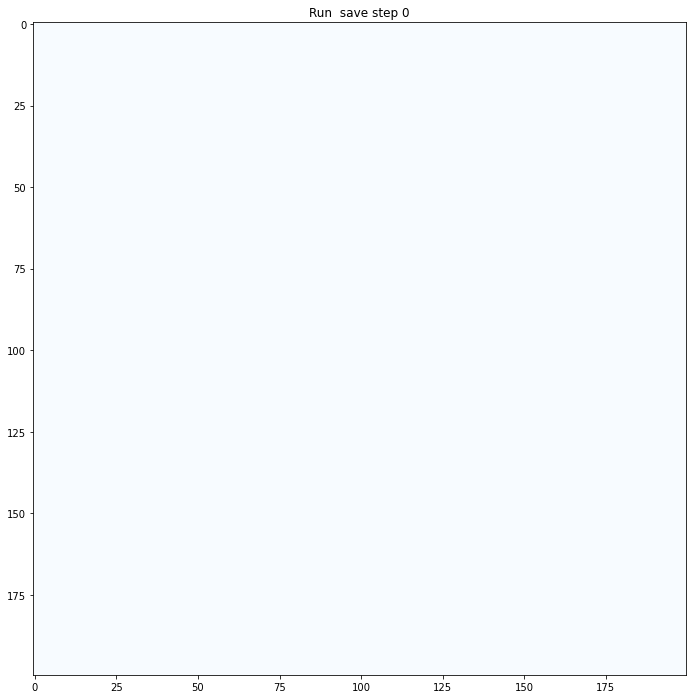

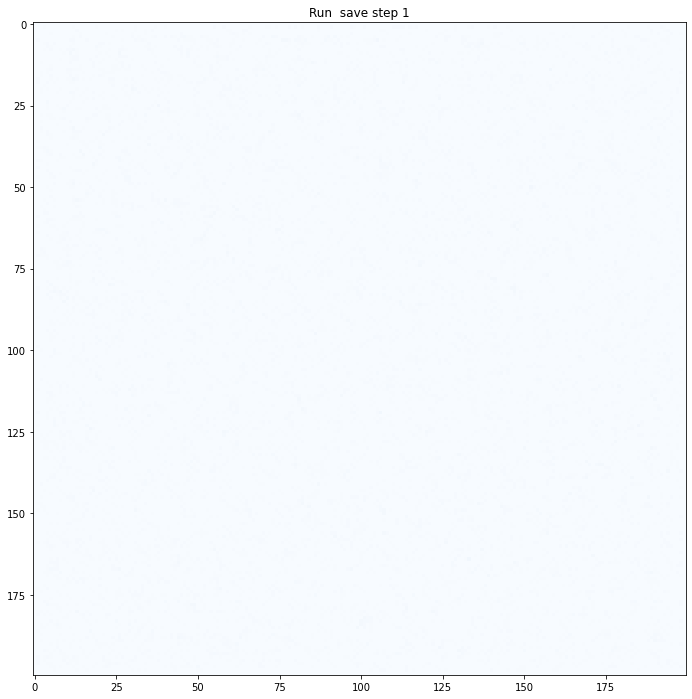

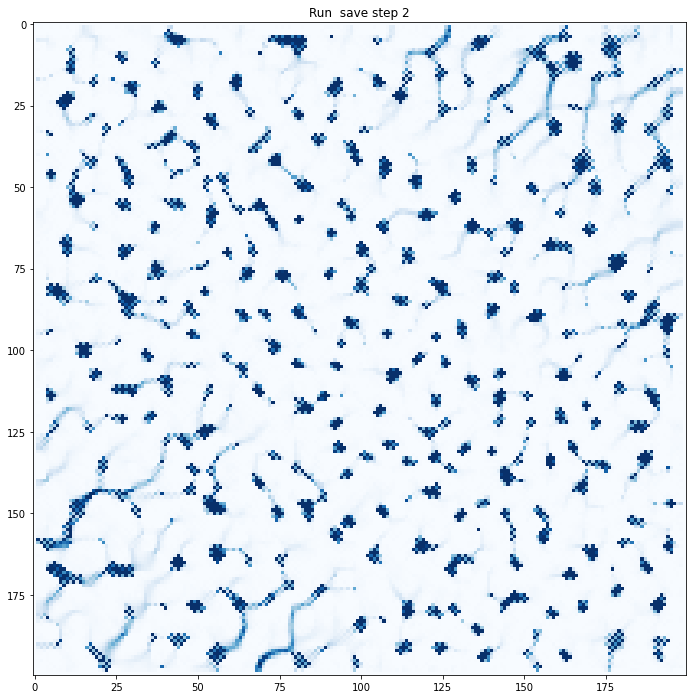

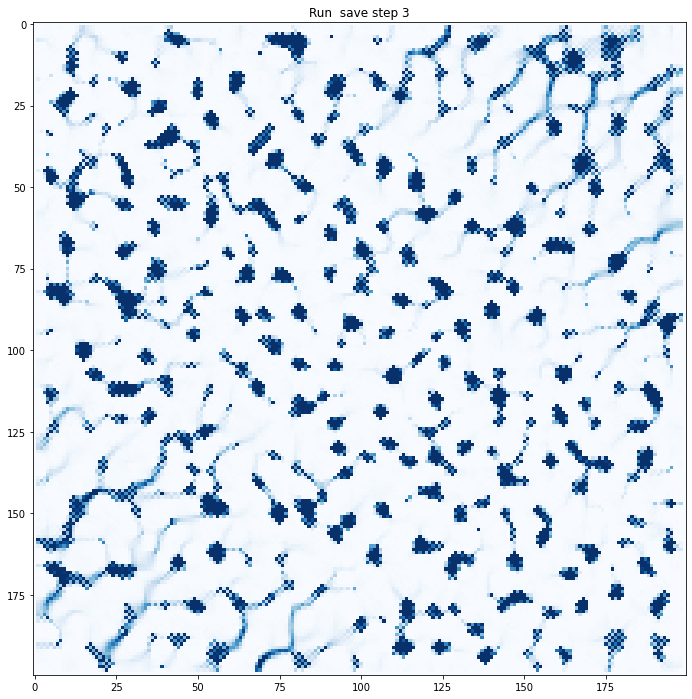

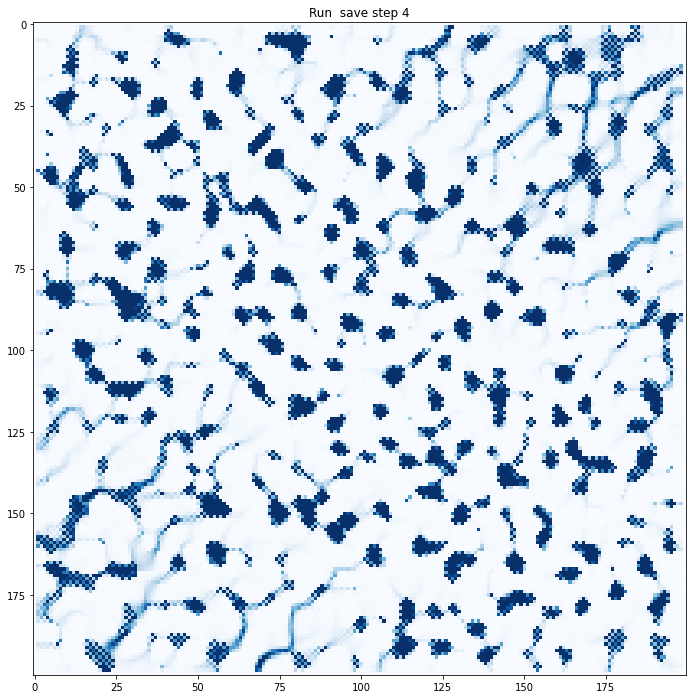

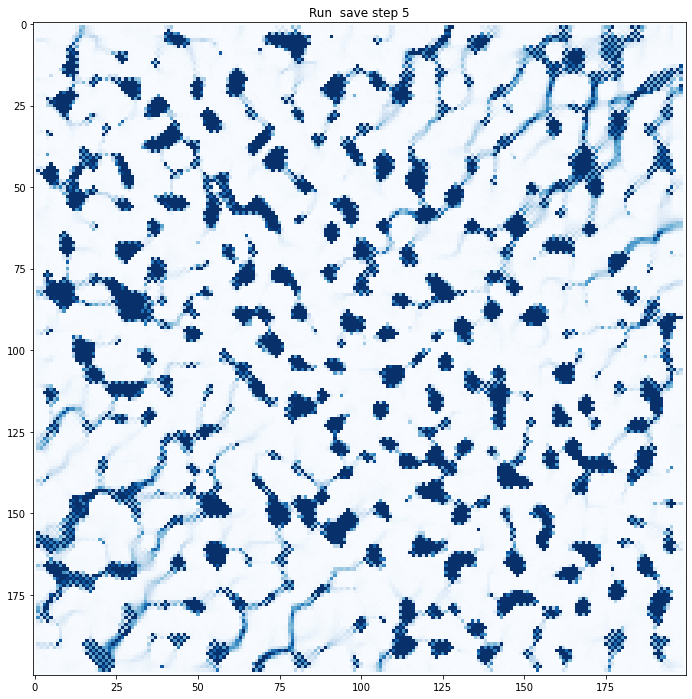

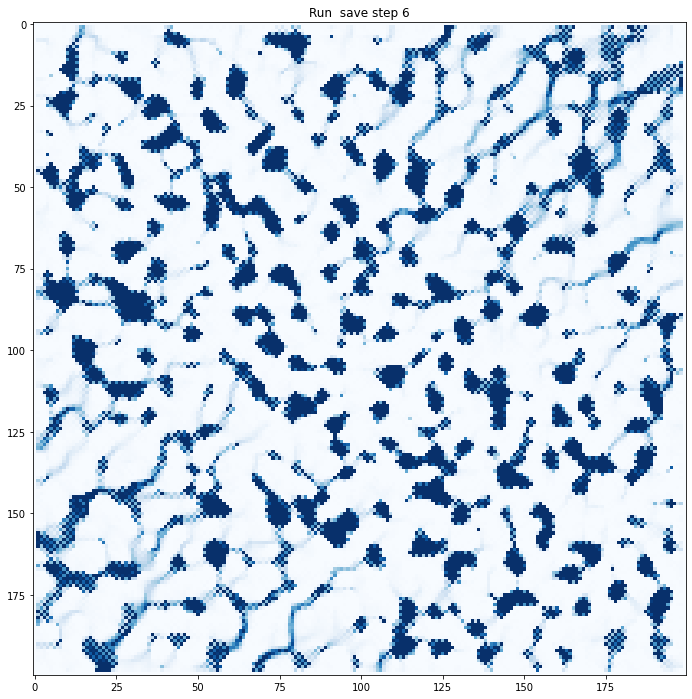

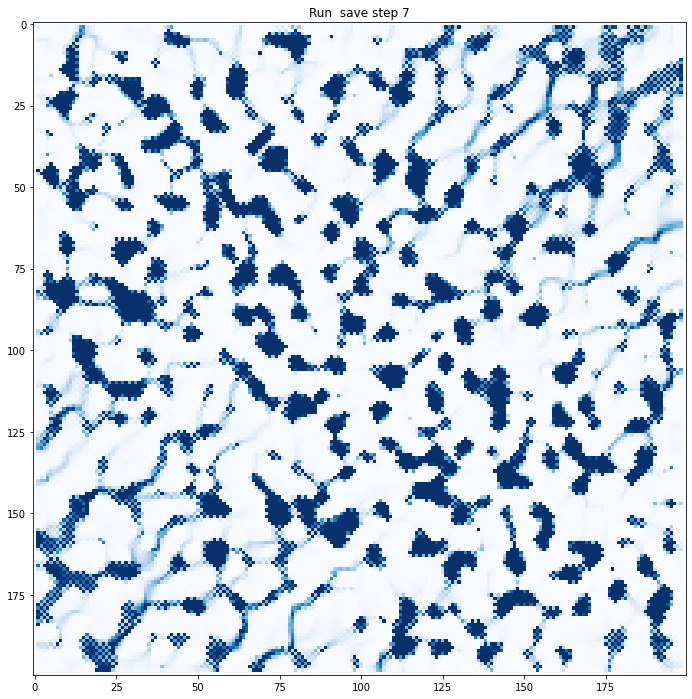

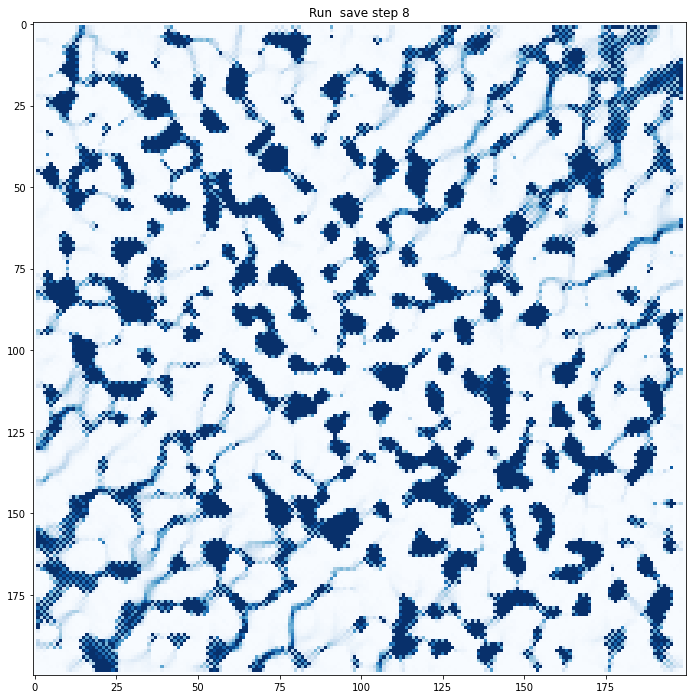

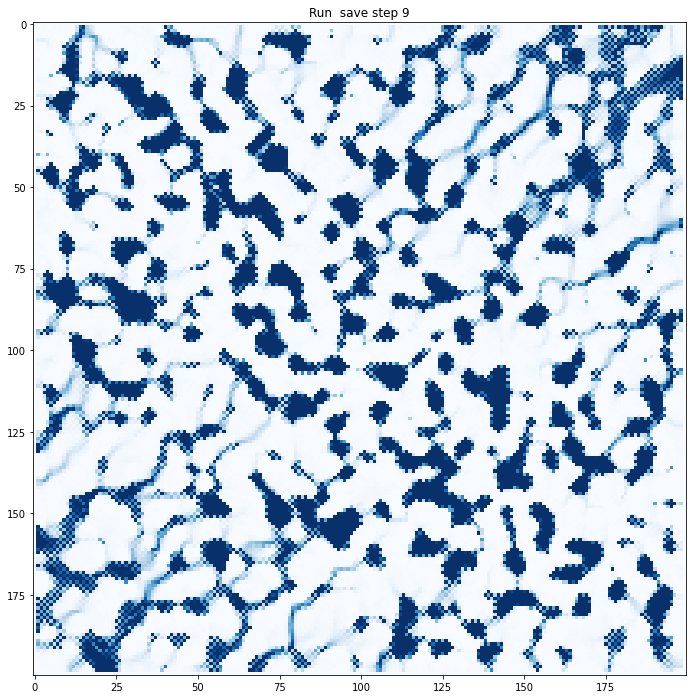

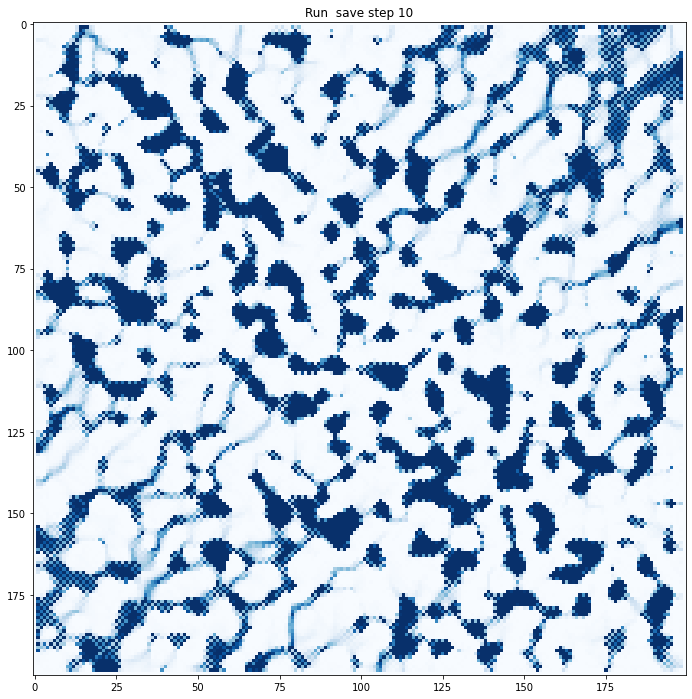

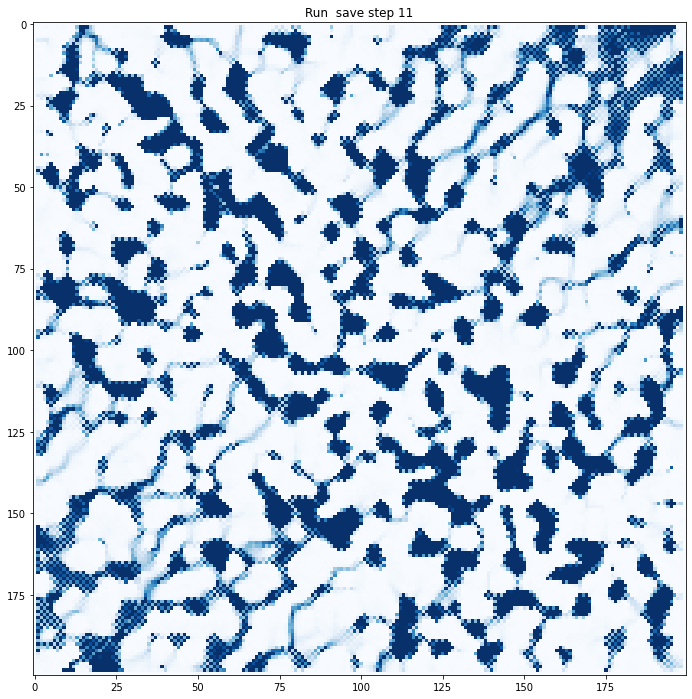

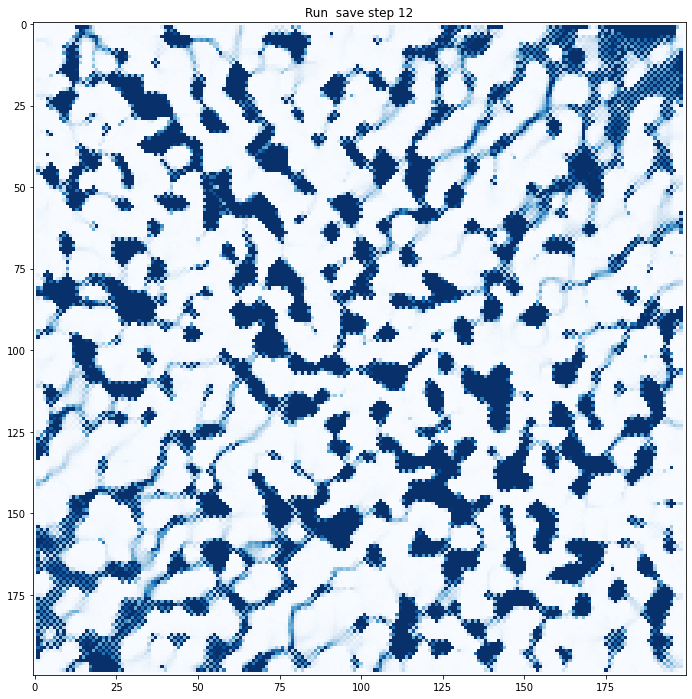

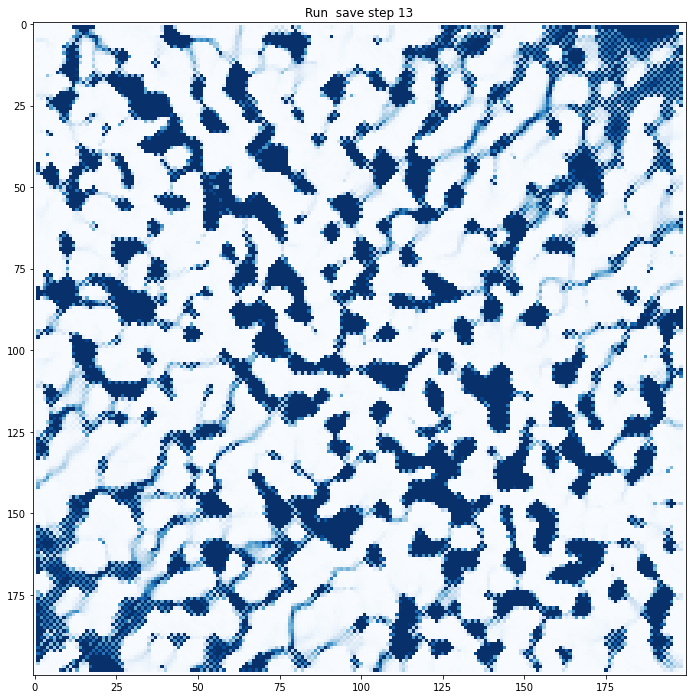

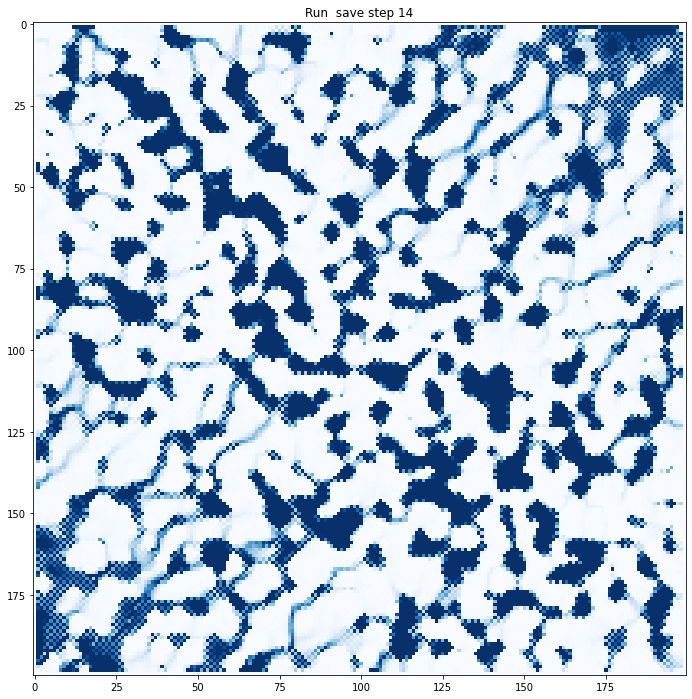

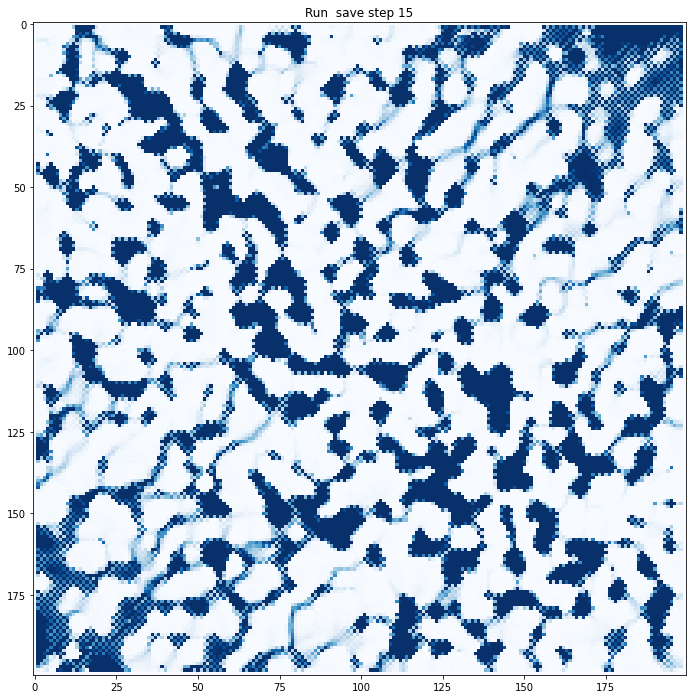

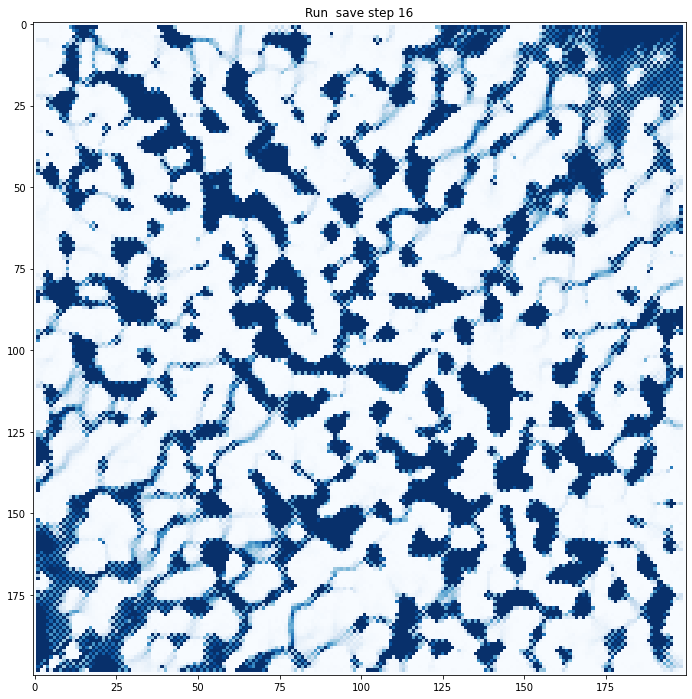

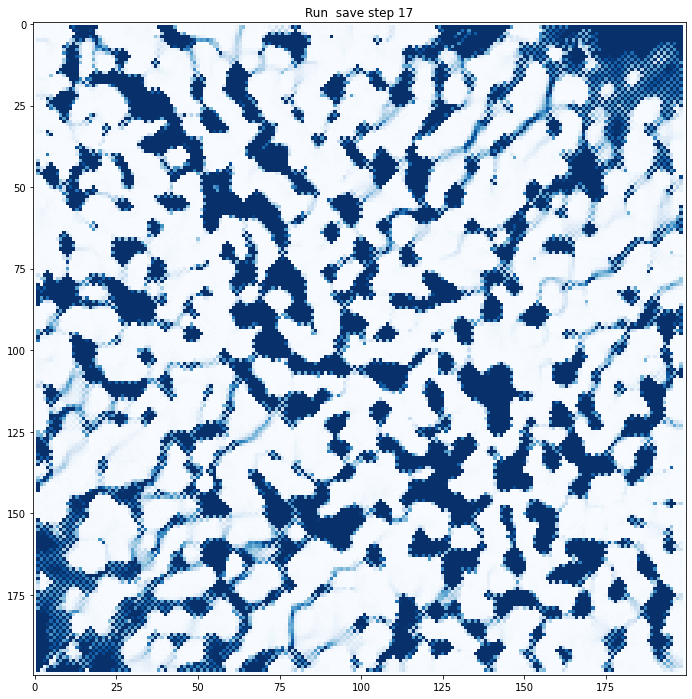

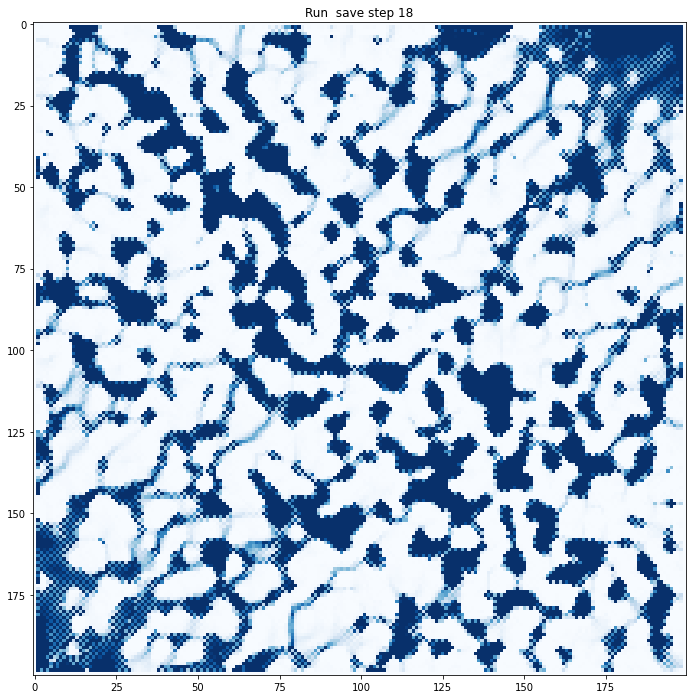

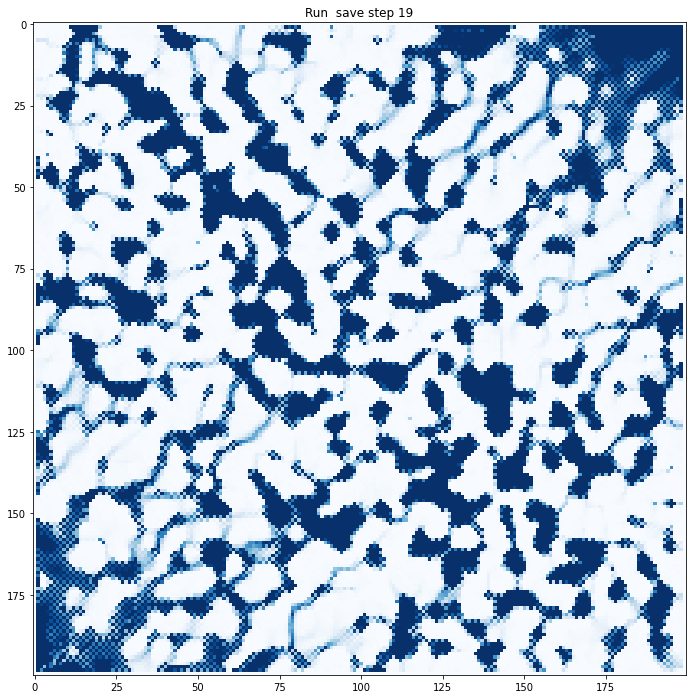

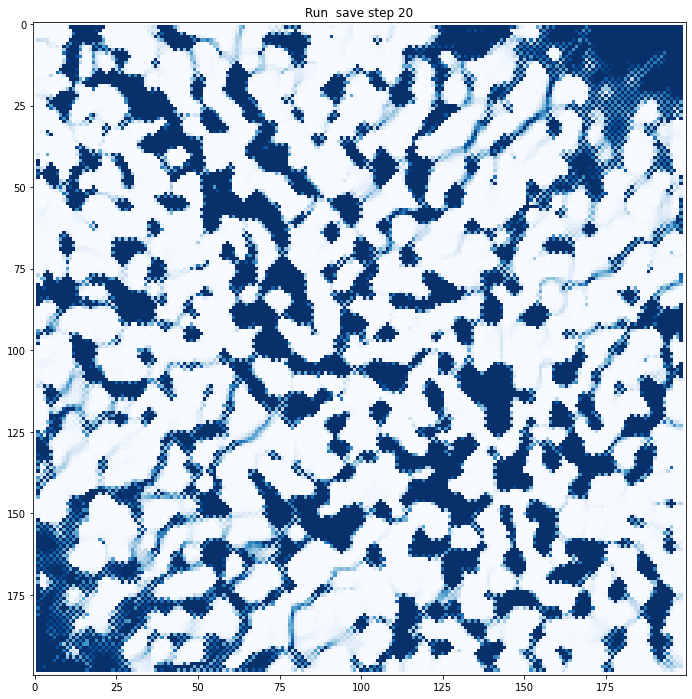

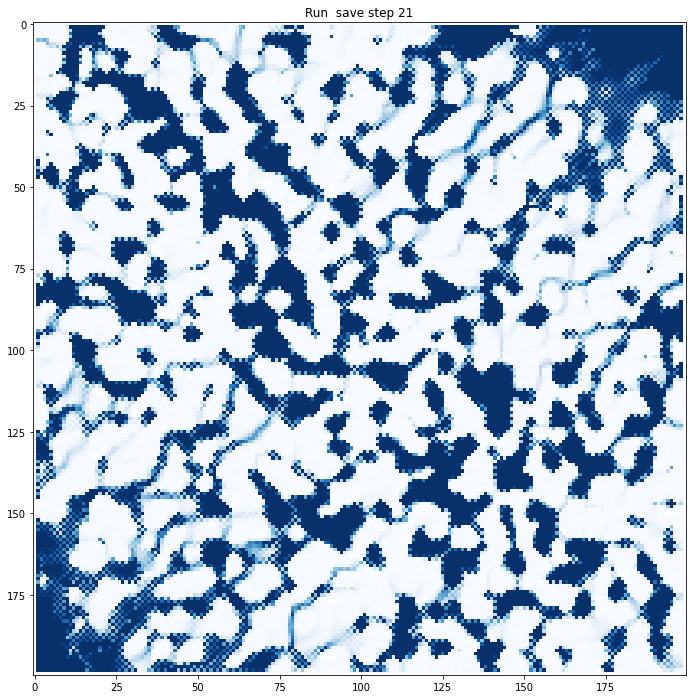

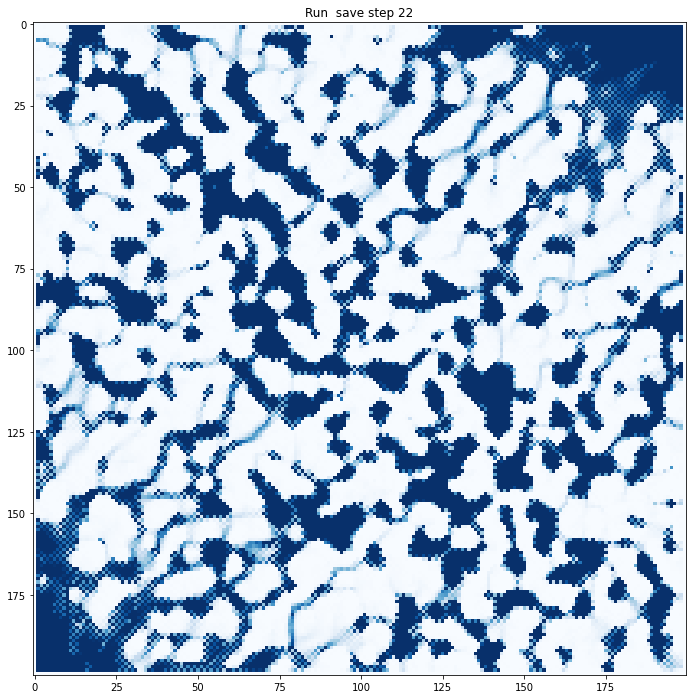

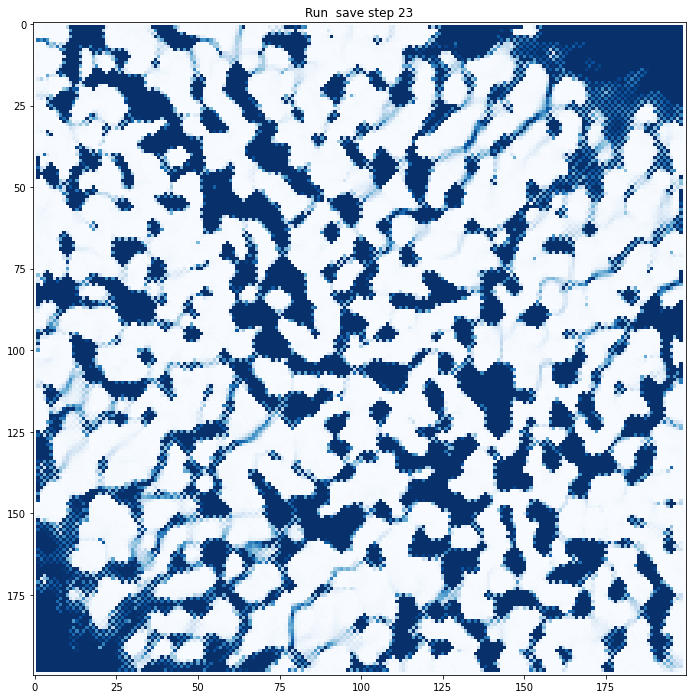

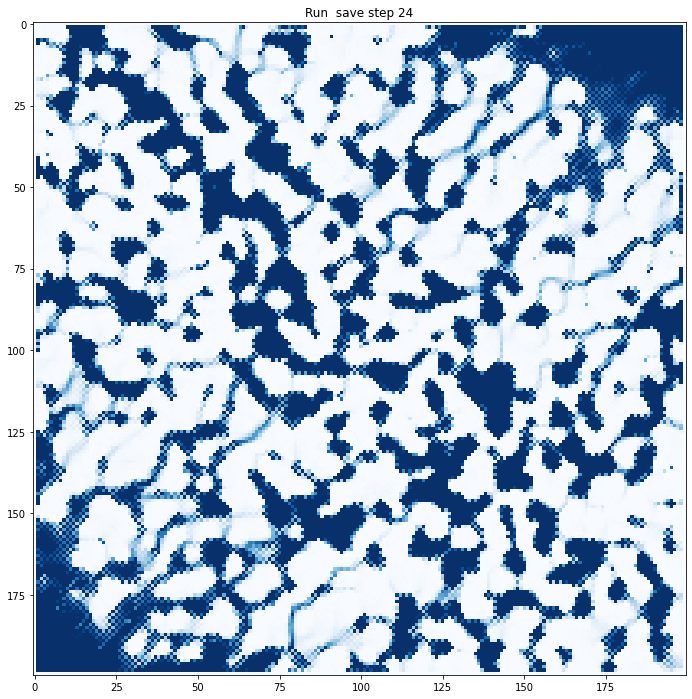

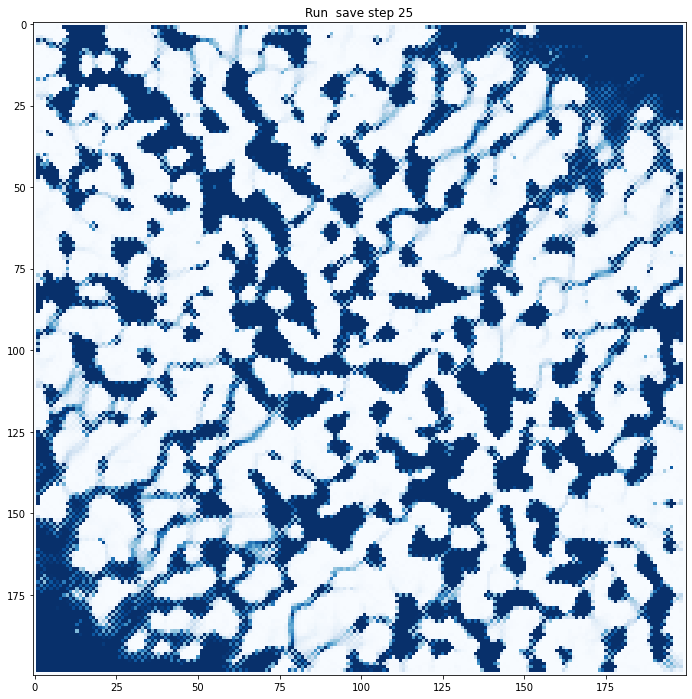

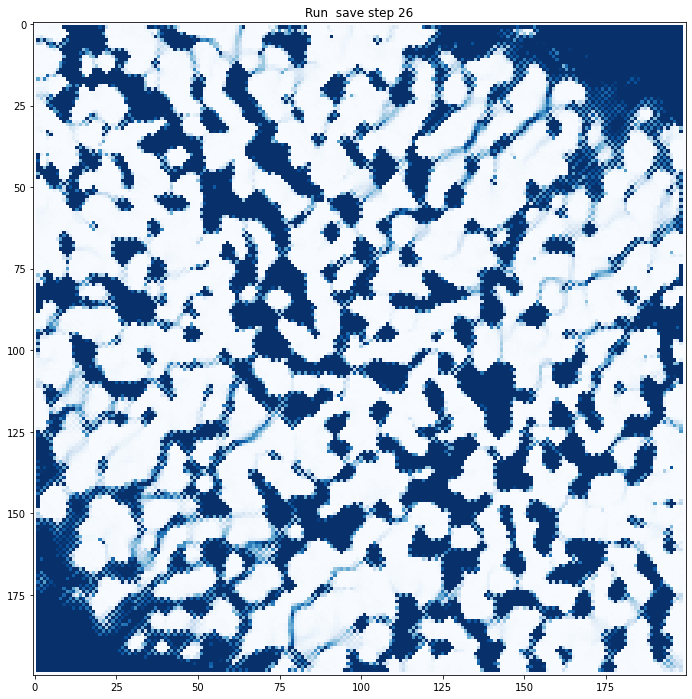

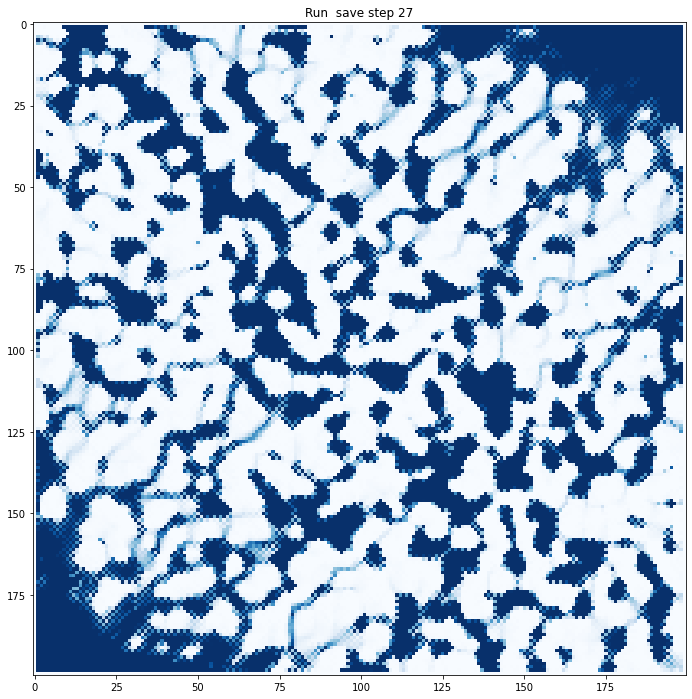

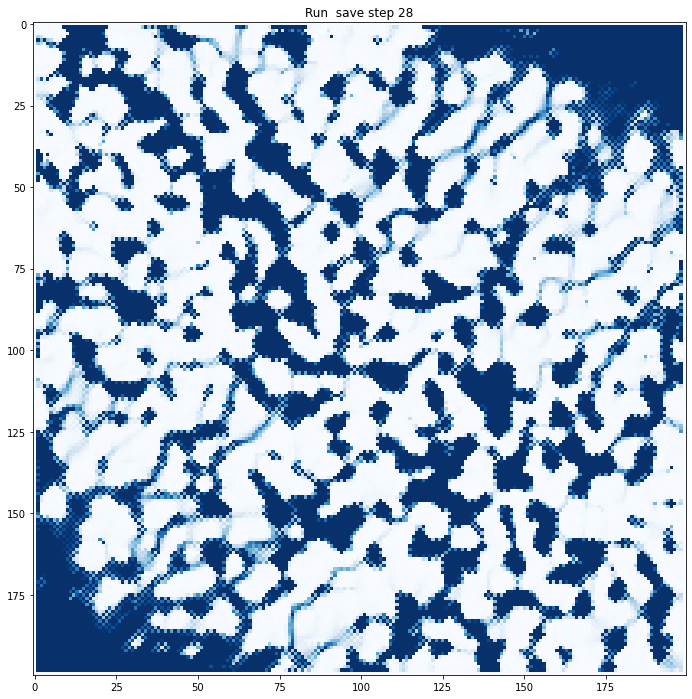

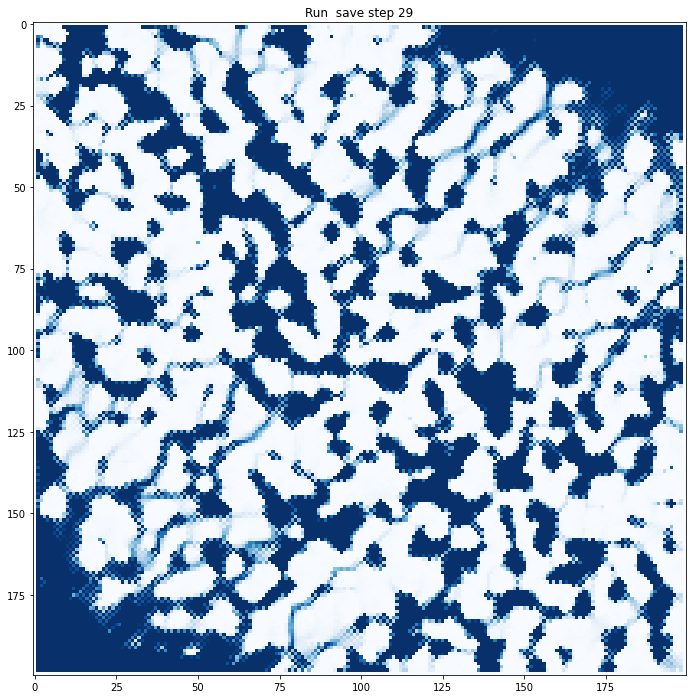

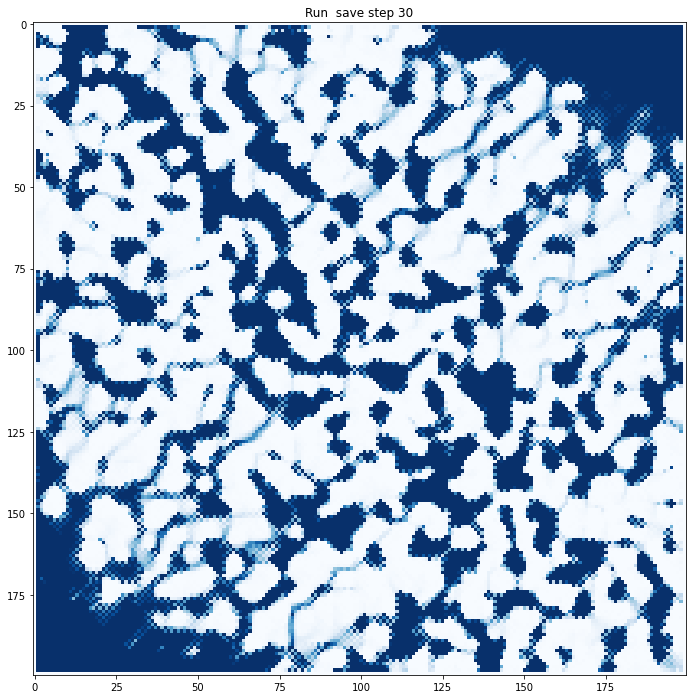

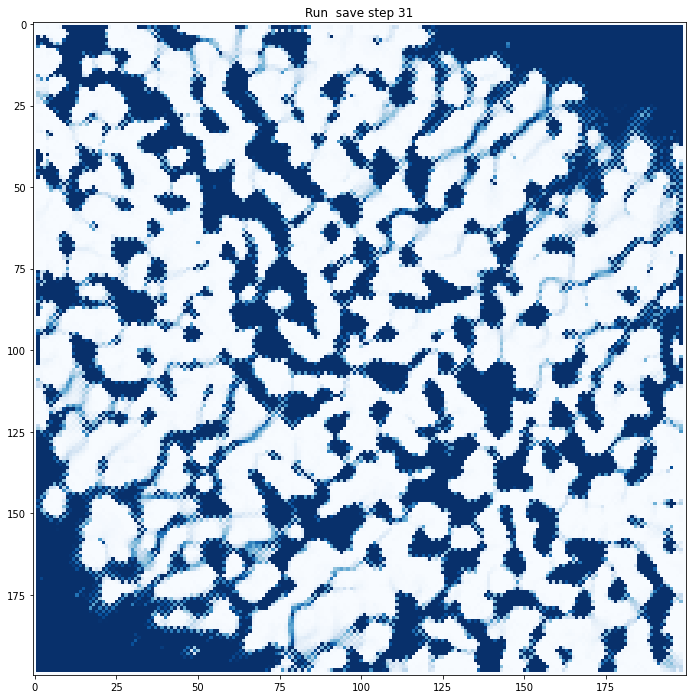

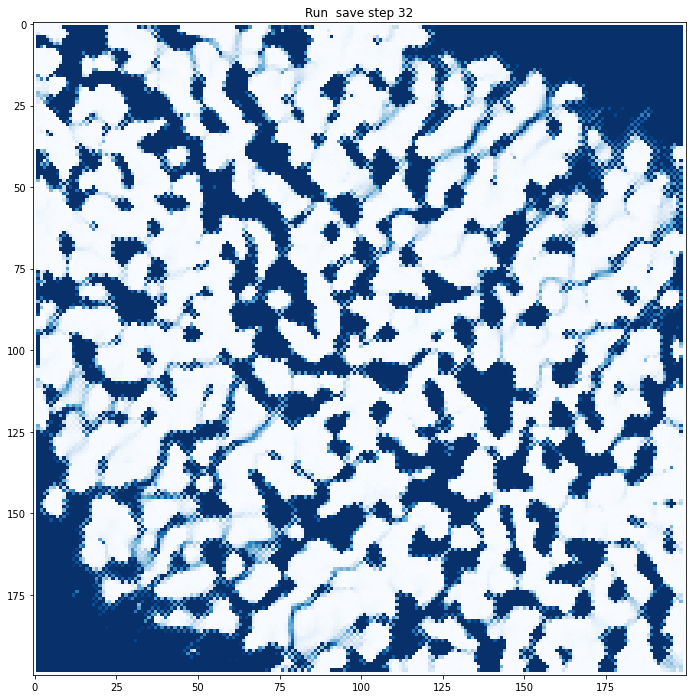

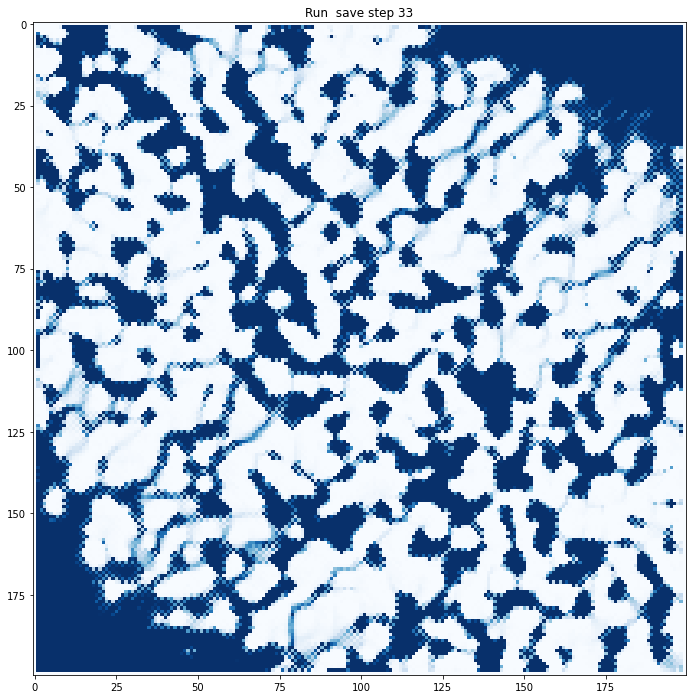

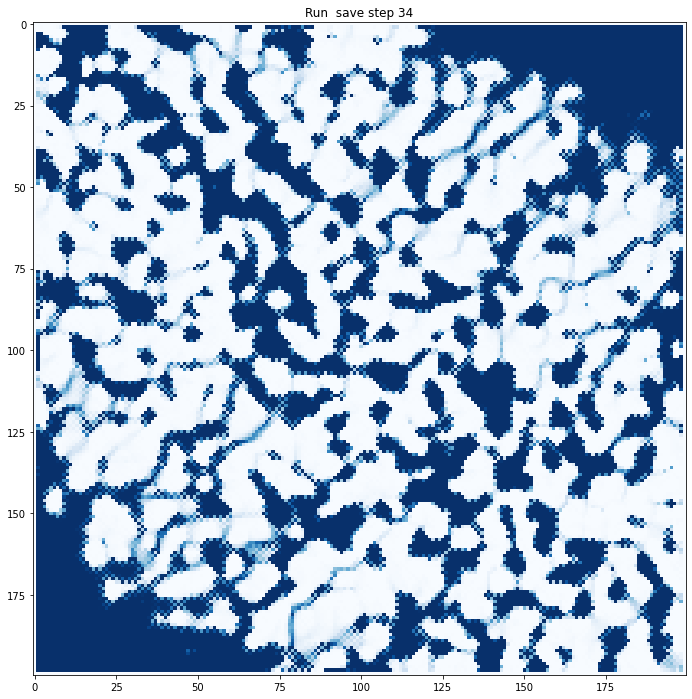

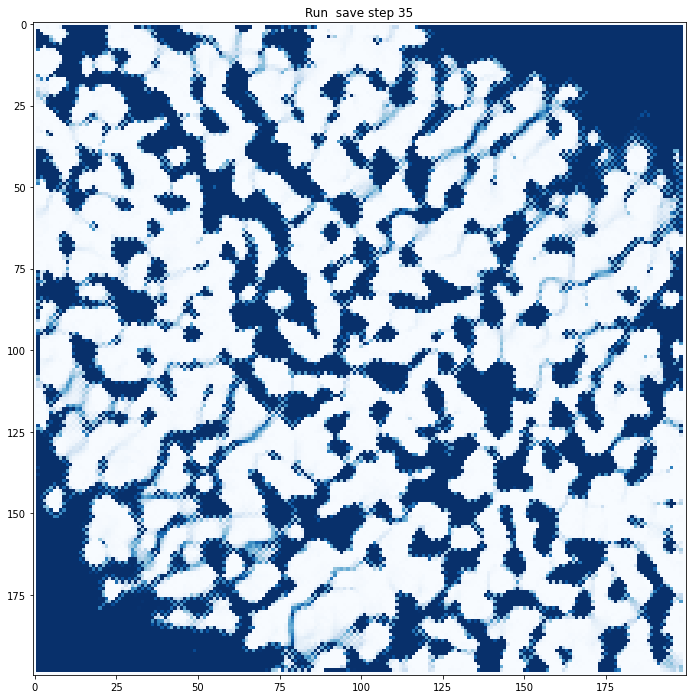

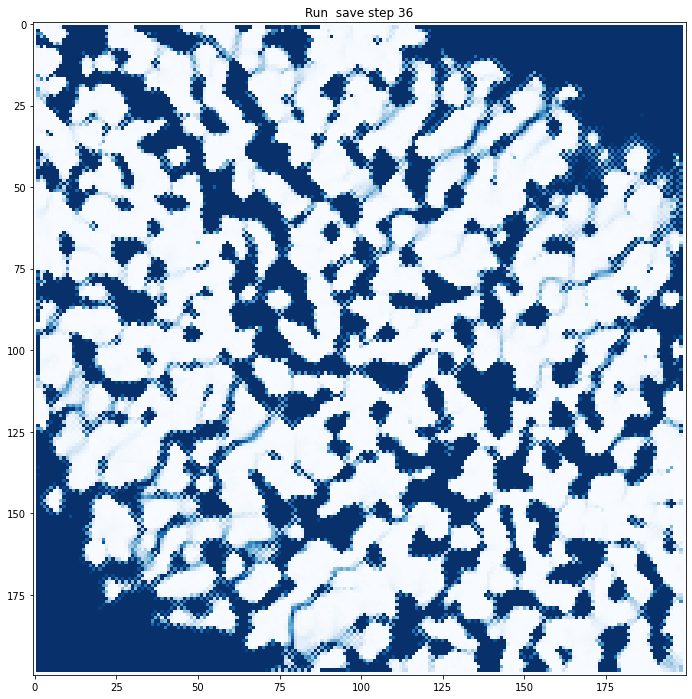

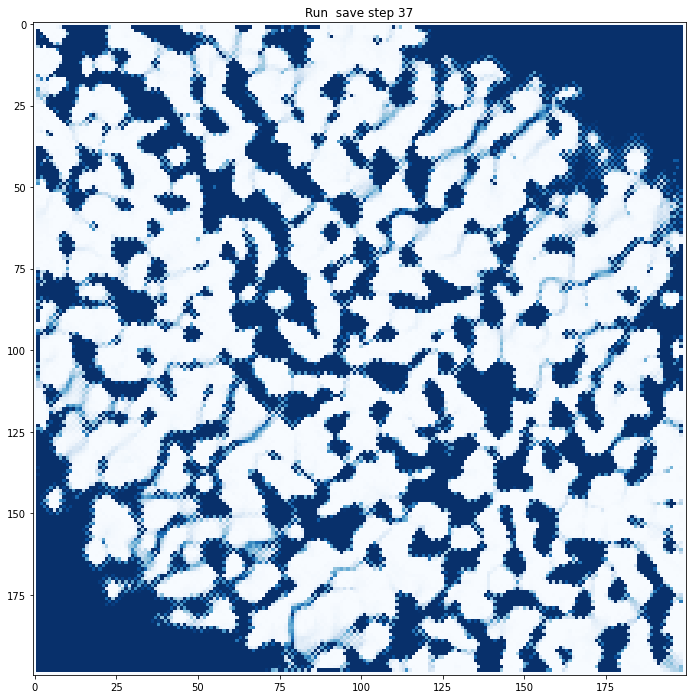

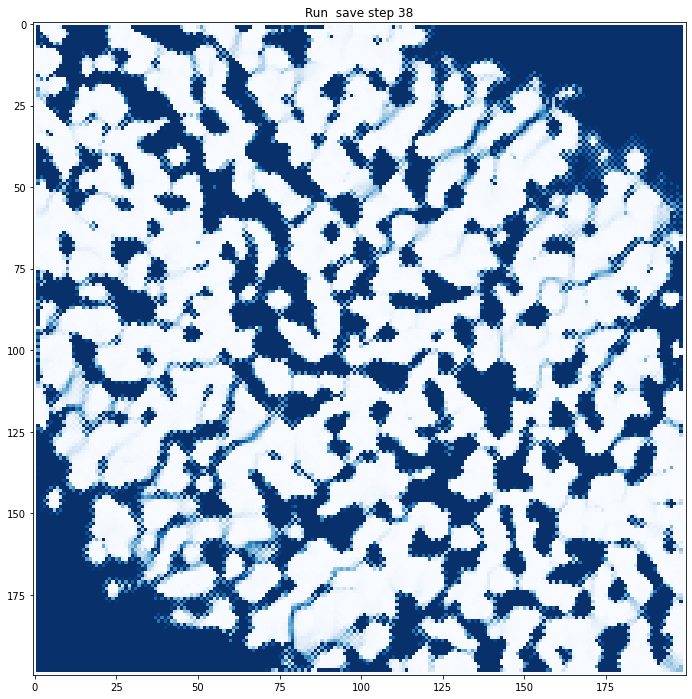

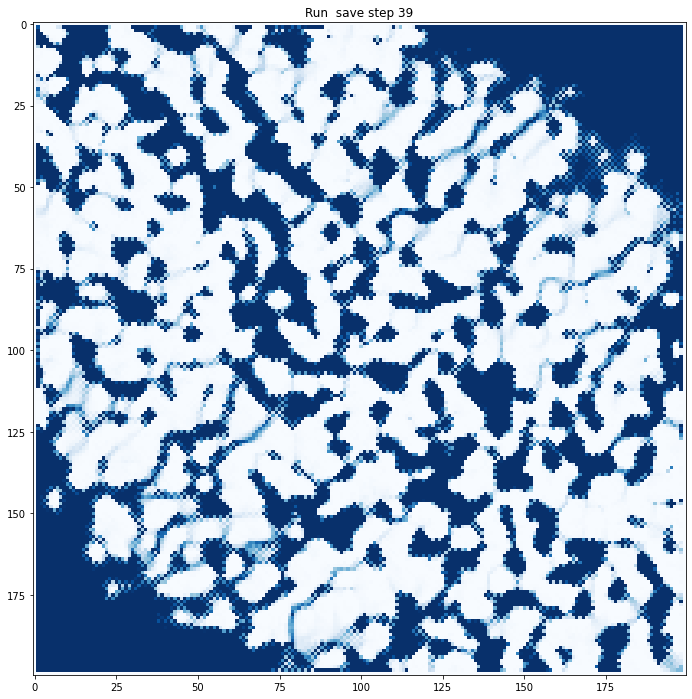

In [83]:
for i in np.arange(40):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    title = "Run  save step " + str(i)
    ax.set_title(title)
    
#     tmp = ndimage.zoom(all_gravel[i] + all_rock[i], 4)
    tmp = all_gravel[i] + all_rock[i]
    ax.imshow(tmp, cmap=plt.cm.terrain, )

#         ax.imshow(all_gravel[j][i], cmap=plt.cm.terrain, )
#     tmp = ndimage.zoom(, 4)

#     alphas = all_waters[i] / 10
#     alphas[alphas > 1] = 1
#     ax.imshow(all_waters[i], cmap=plt.cm.Blues, vmin=0, vmax=10, alpha=alphas)
    ax.imshow(all_waters[i], cmap=plt.cm.Blues, vmin=0, vmax=10, alpha=1)

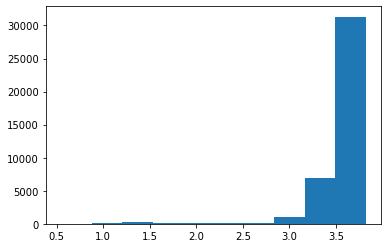

In [70]:
plt.hist(np.log10(tmp.flatten()))
None

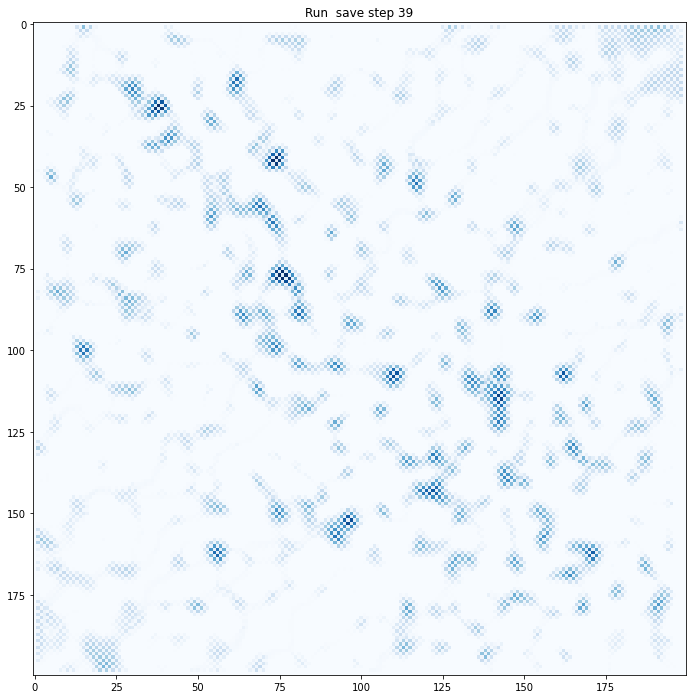

In [79]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
title = "Run  save step " + str(i)
ax.set_title(title)    
# tmp1 = ((all_gravel[-1] + all_rock[-1]) + (all_gravel[-2] + all_rock[-2])) / 2. 
tmp = all_waters[-1]
ax.imshow(tmp, vmax=1000, cmap=plt.cm.Blues)

/tmp/ipykernel_5482/665856109.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 12))


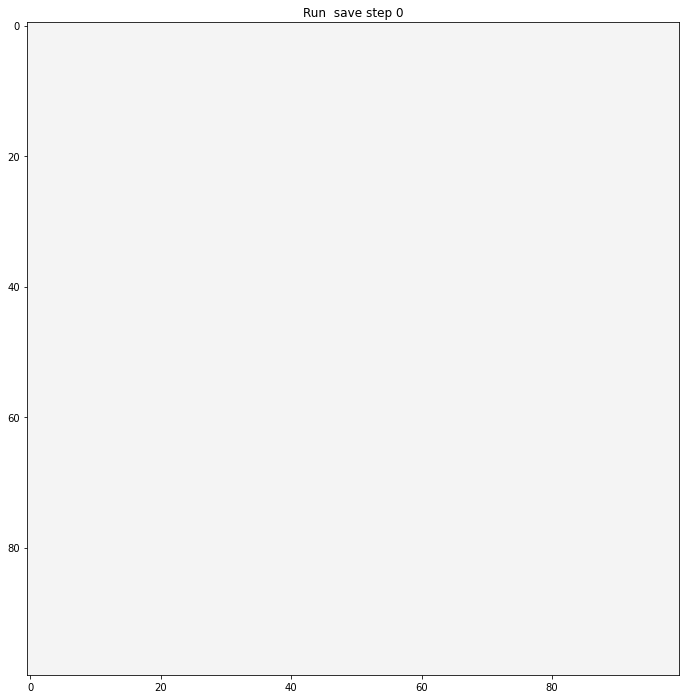

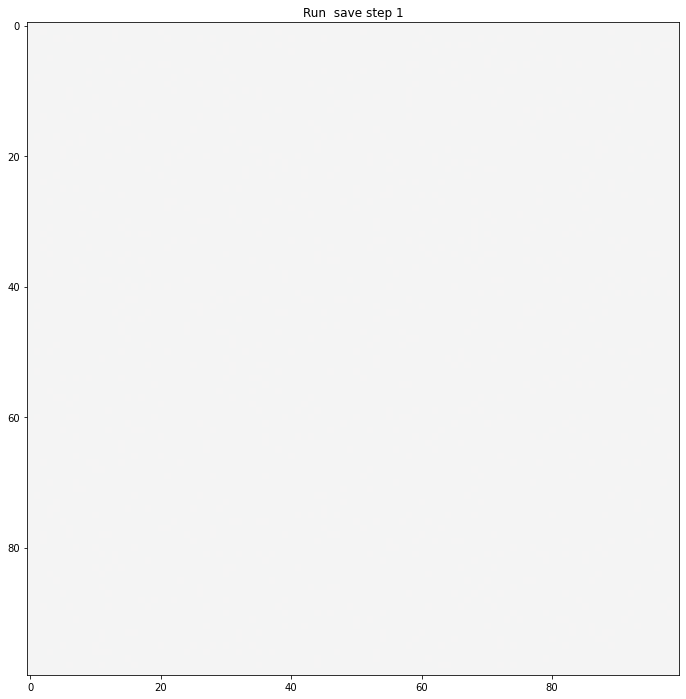

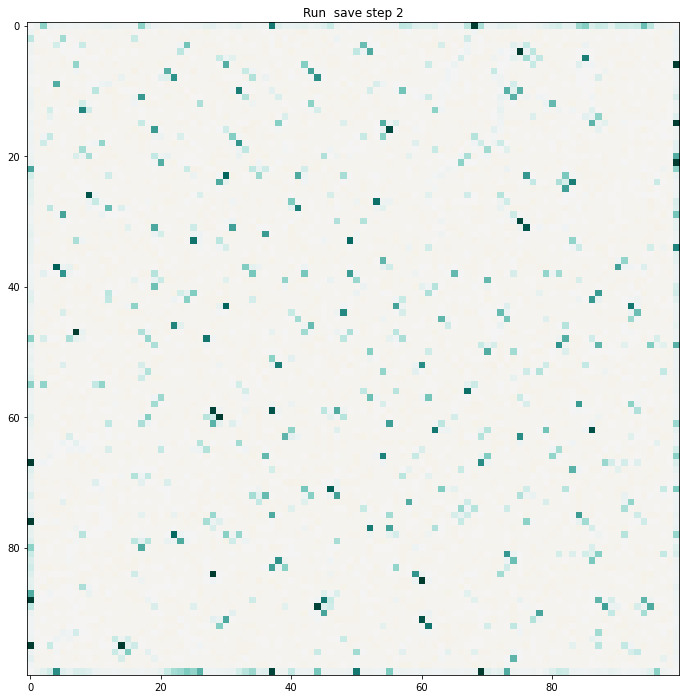

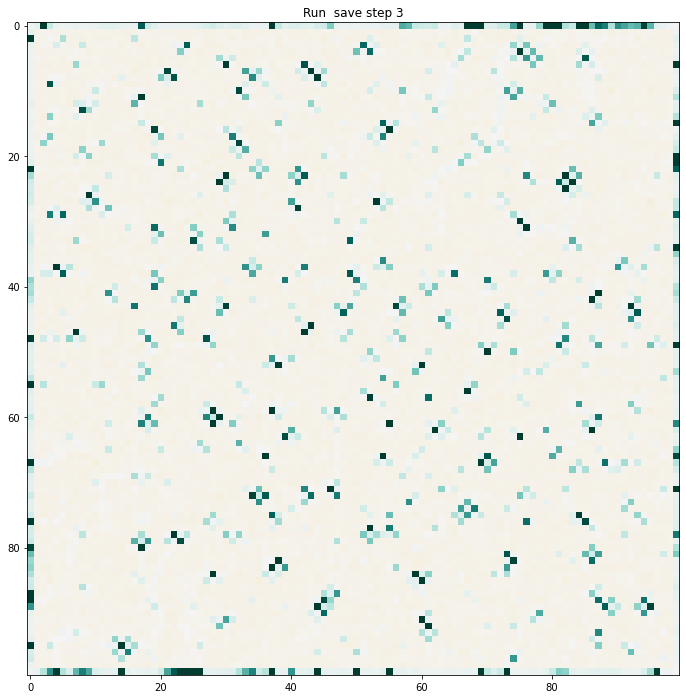

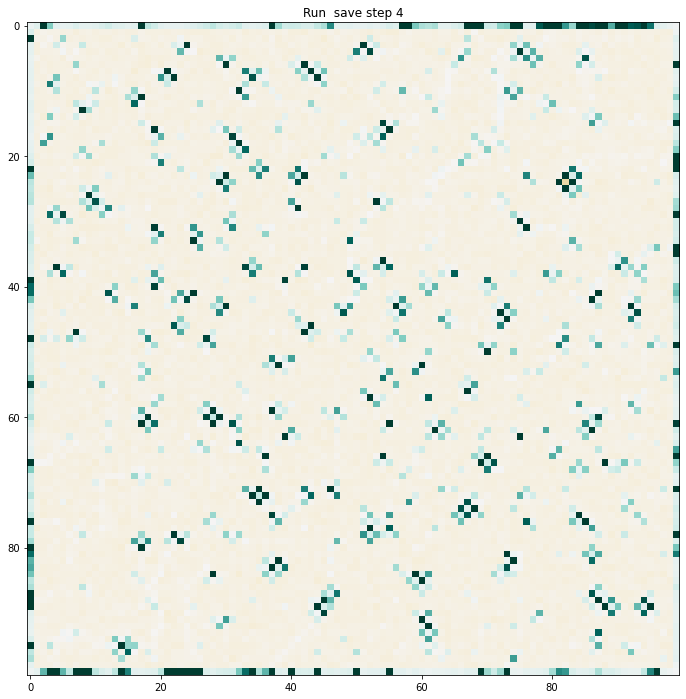

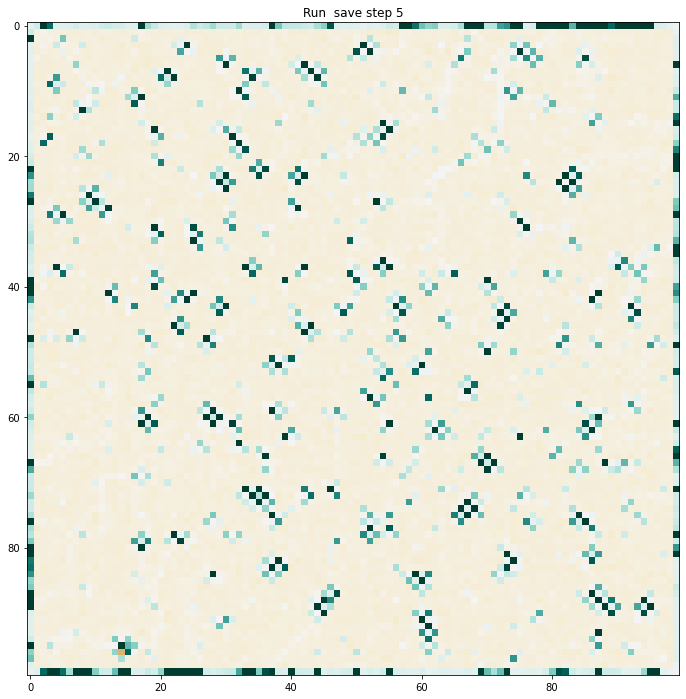

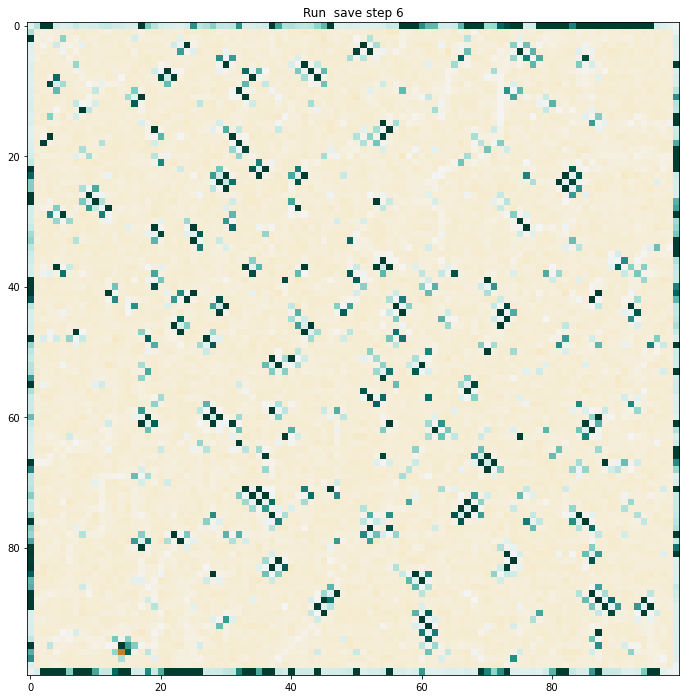

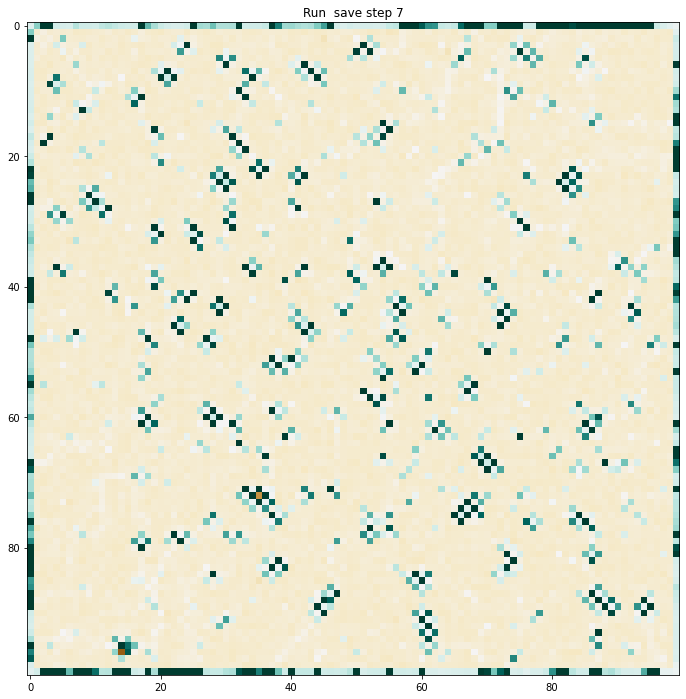

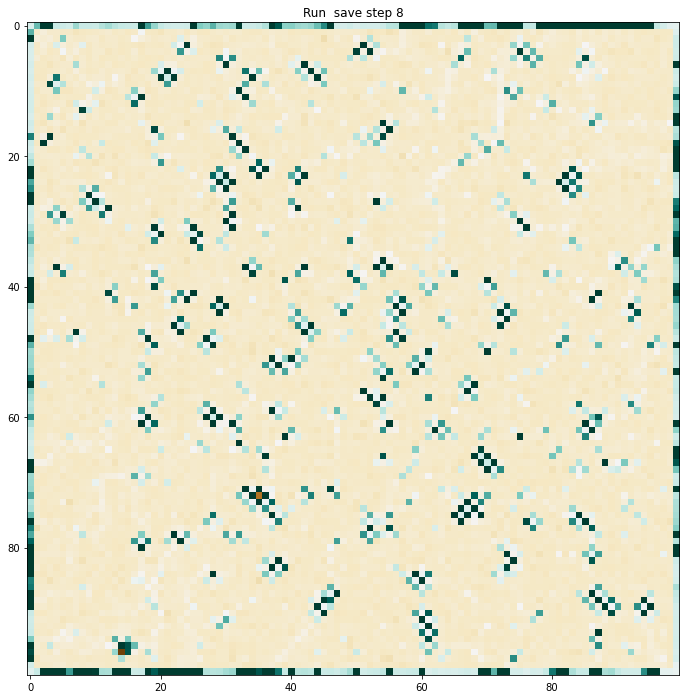

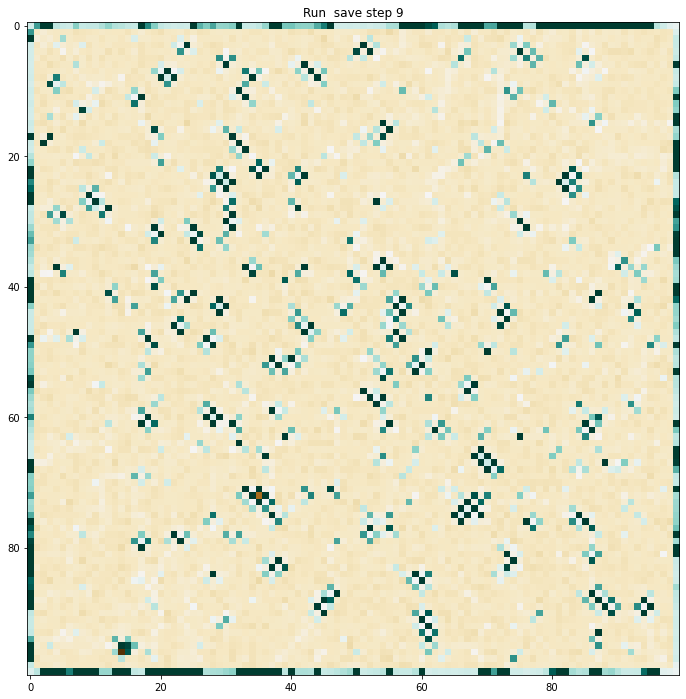

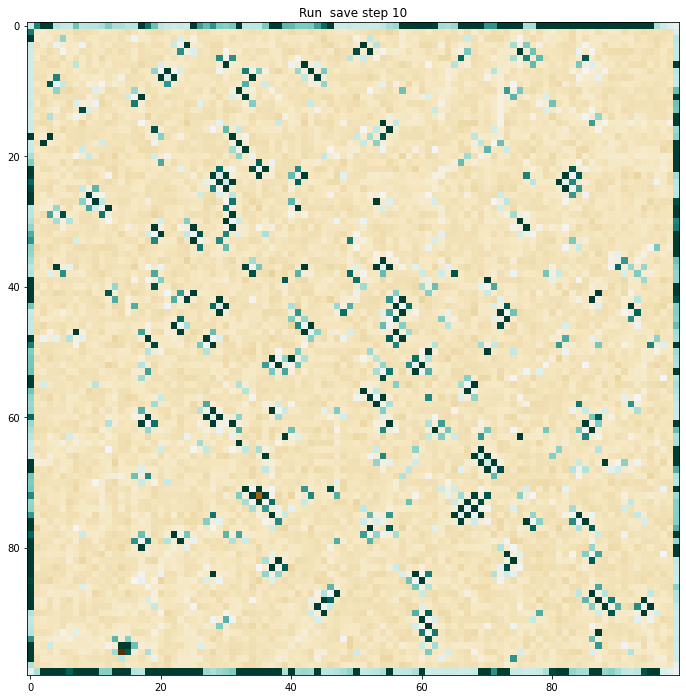

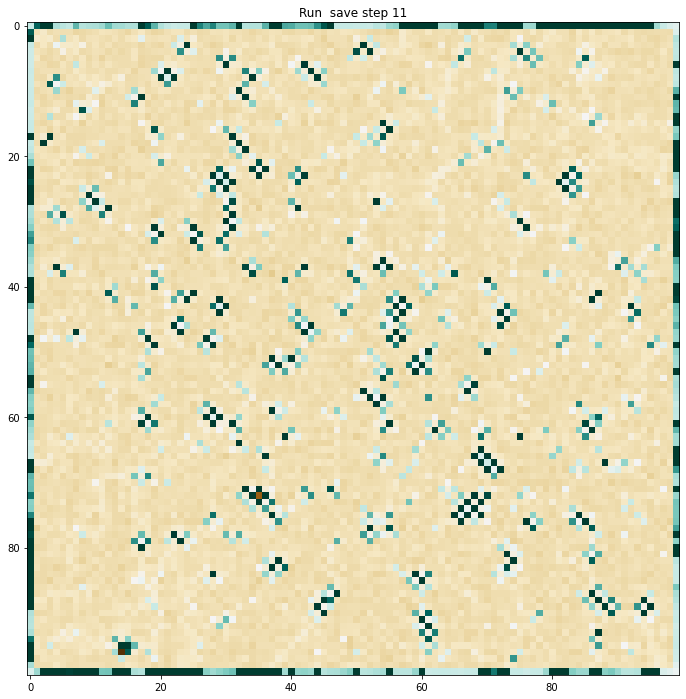

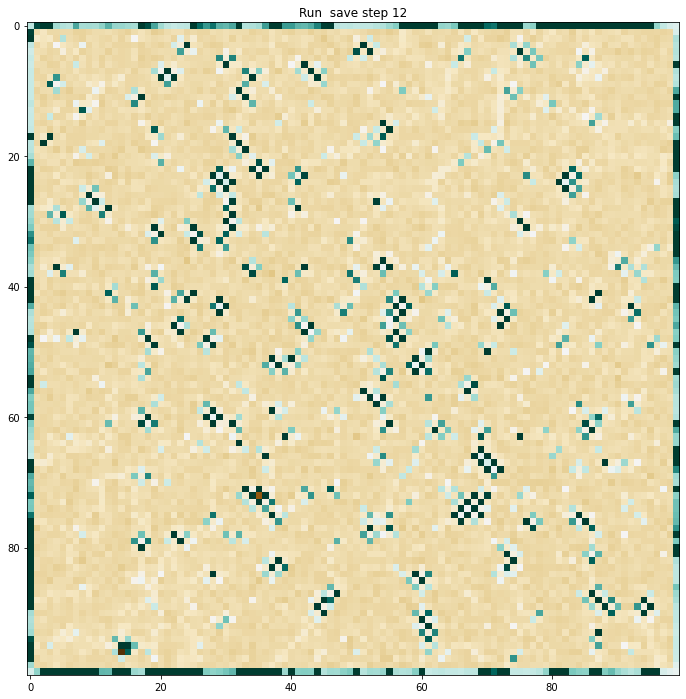

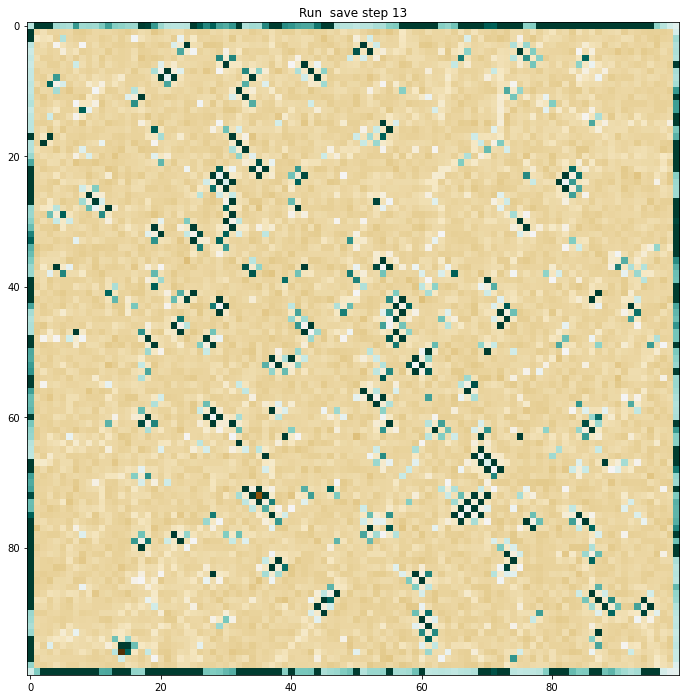

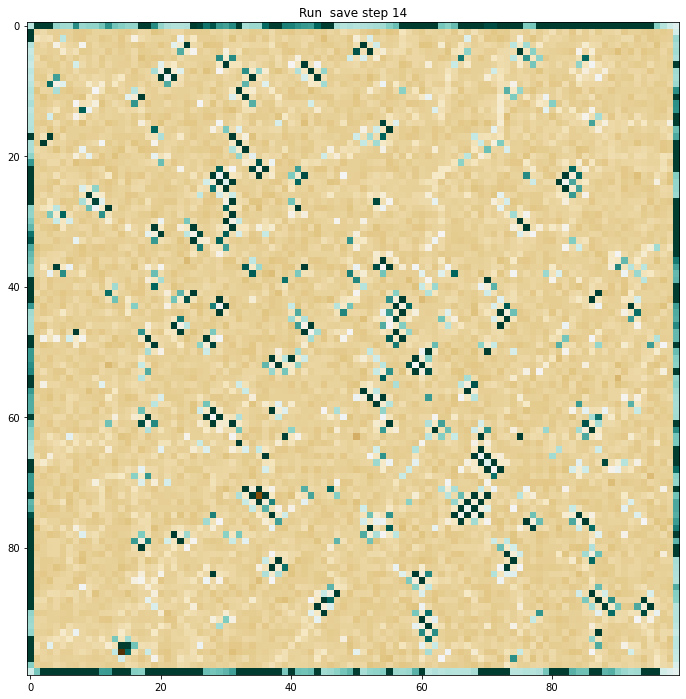

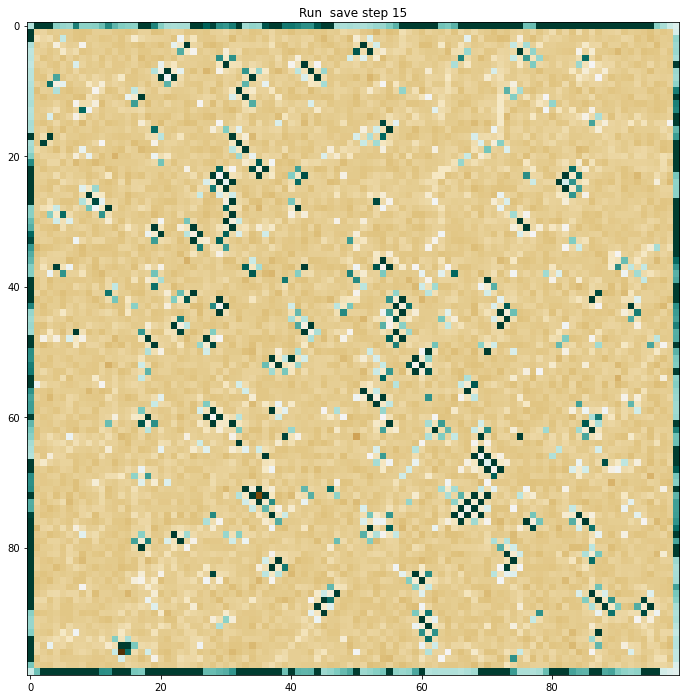

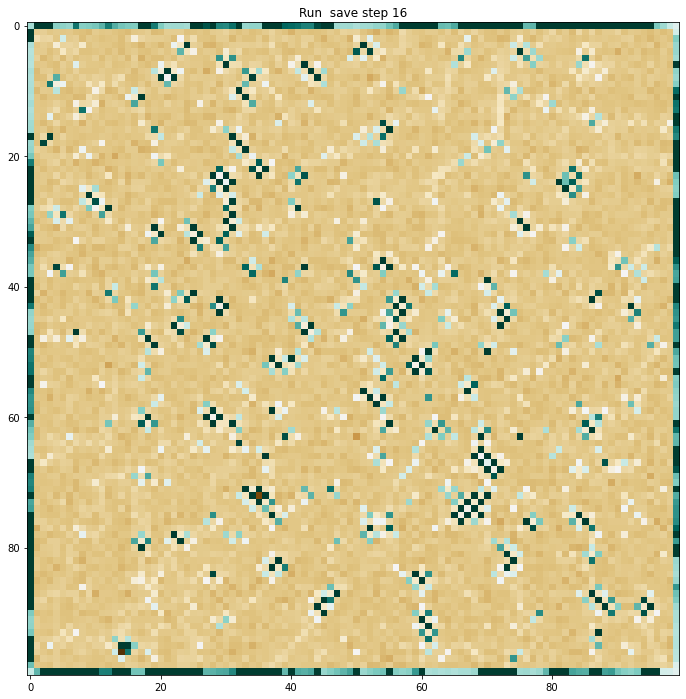

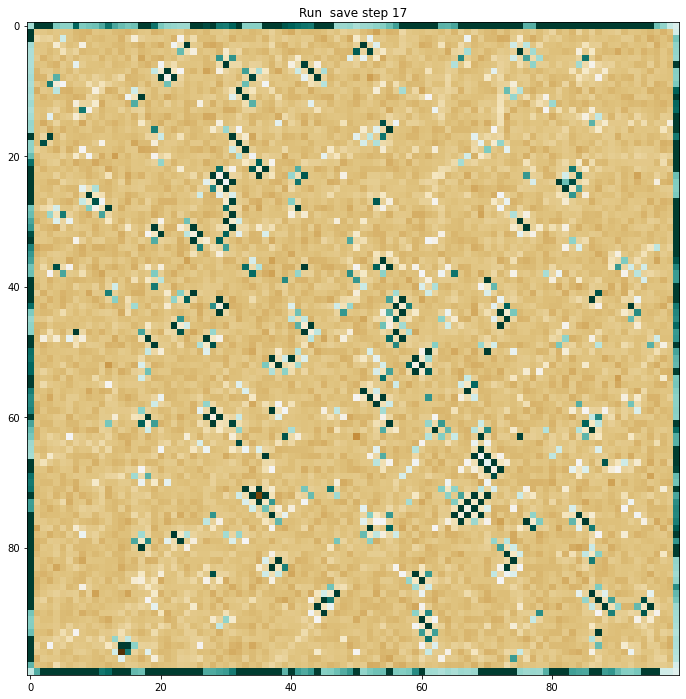

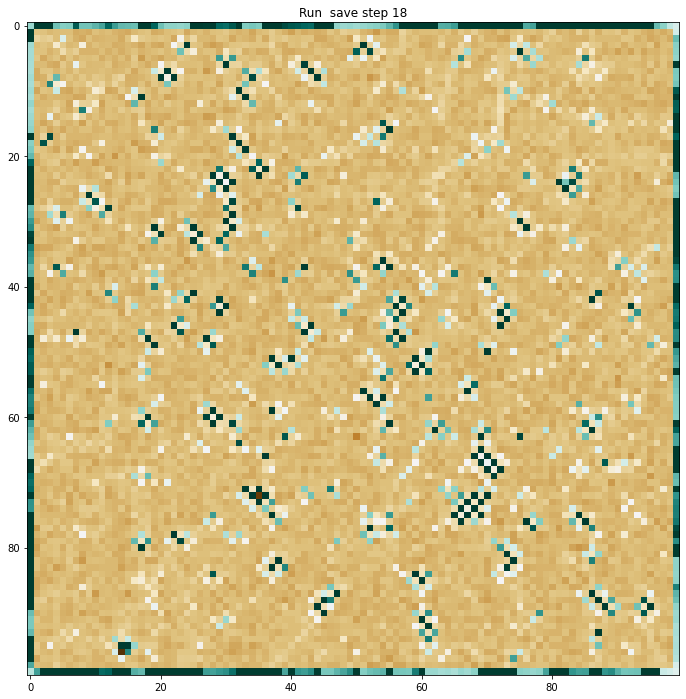

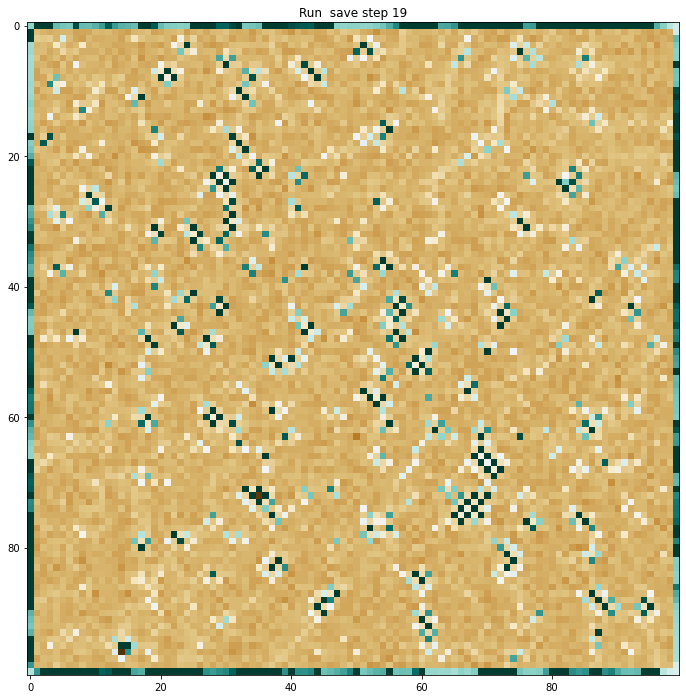

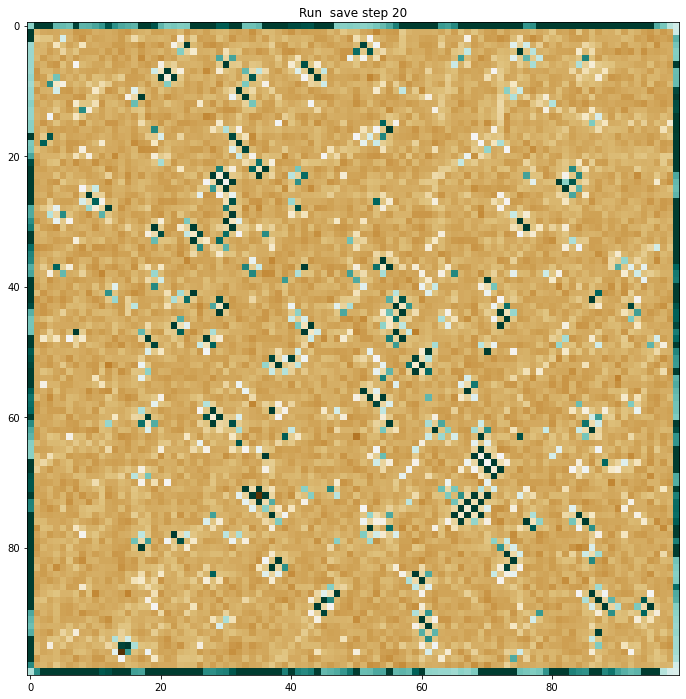

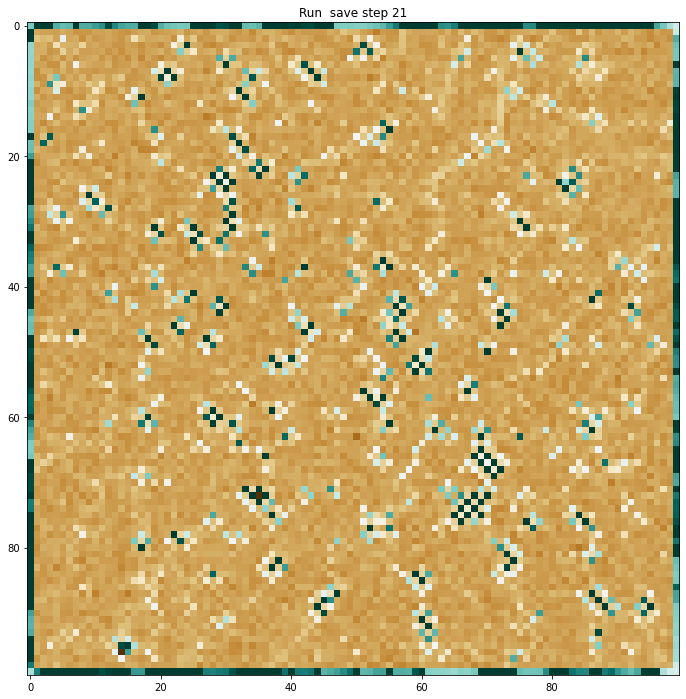

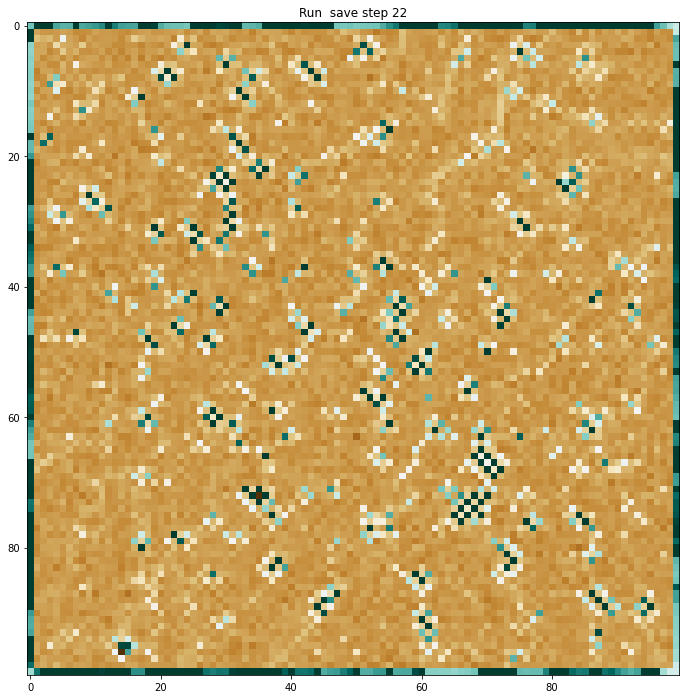

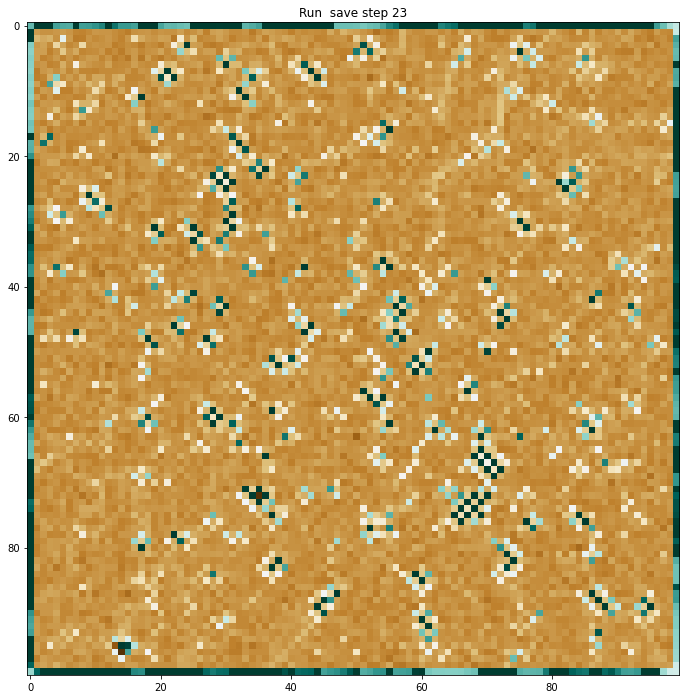

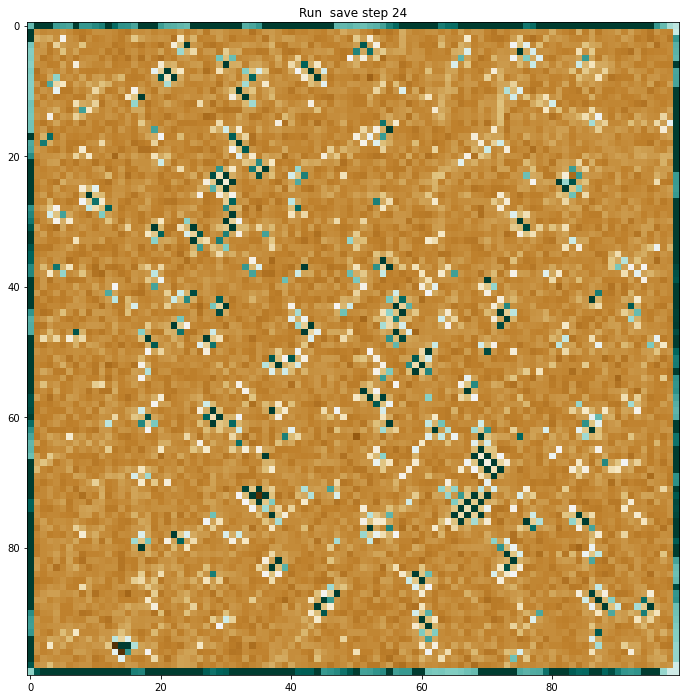

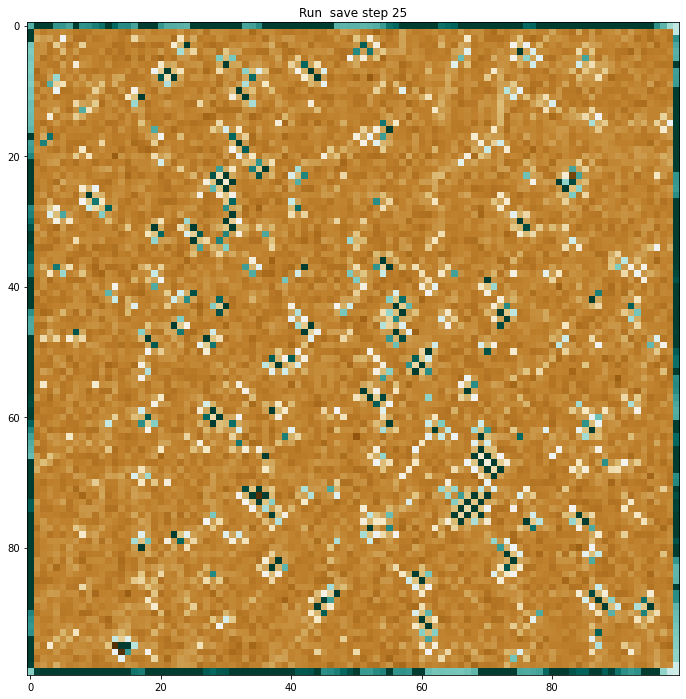

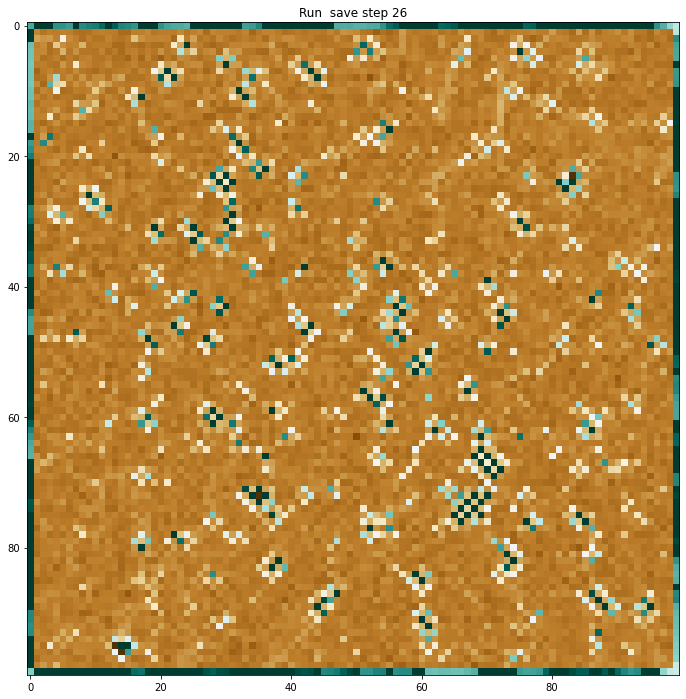

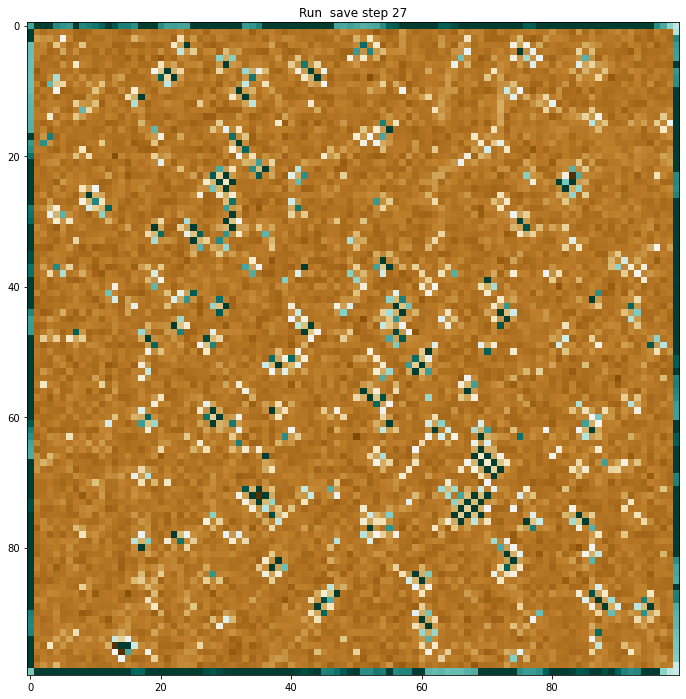

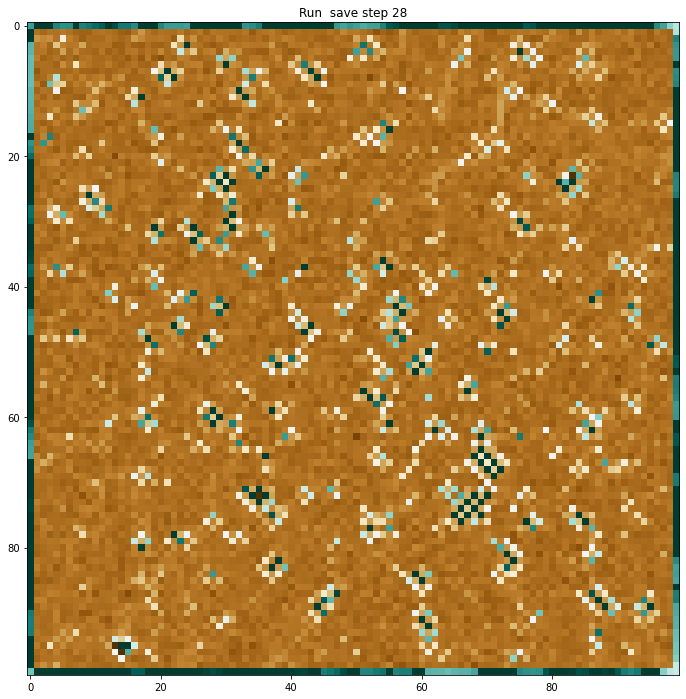

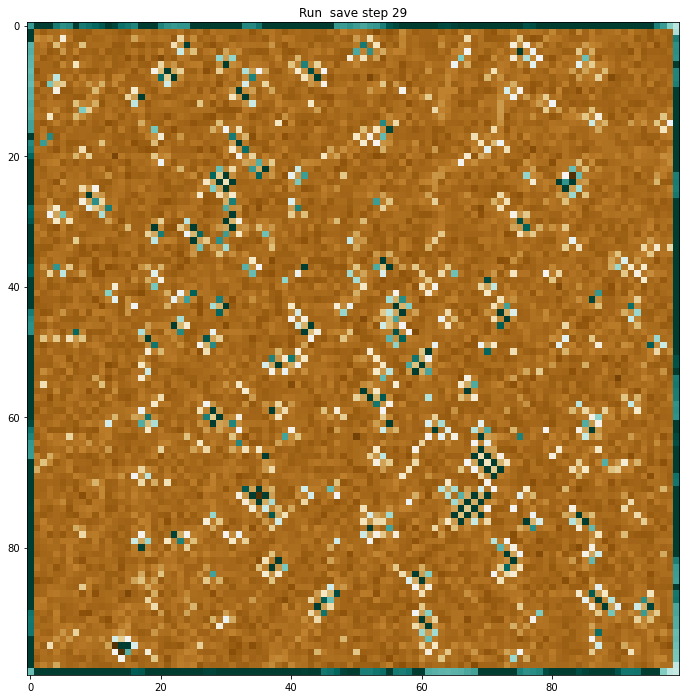

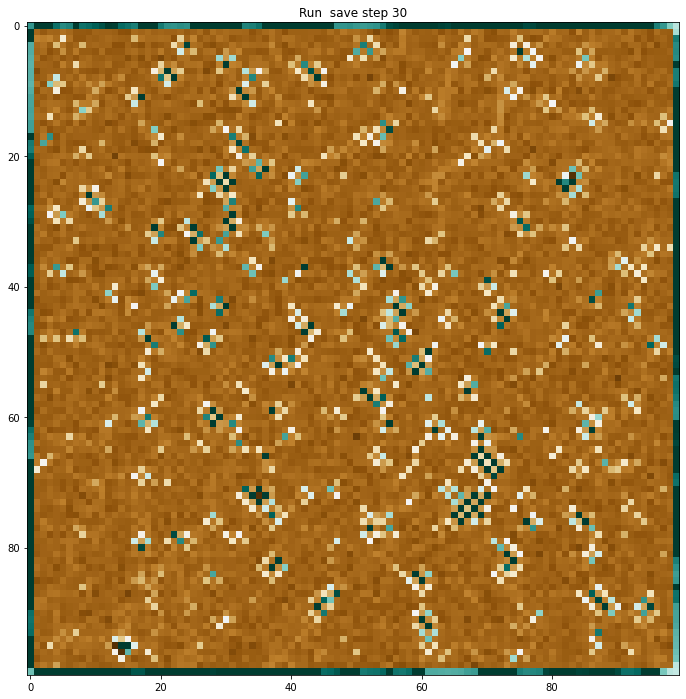

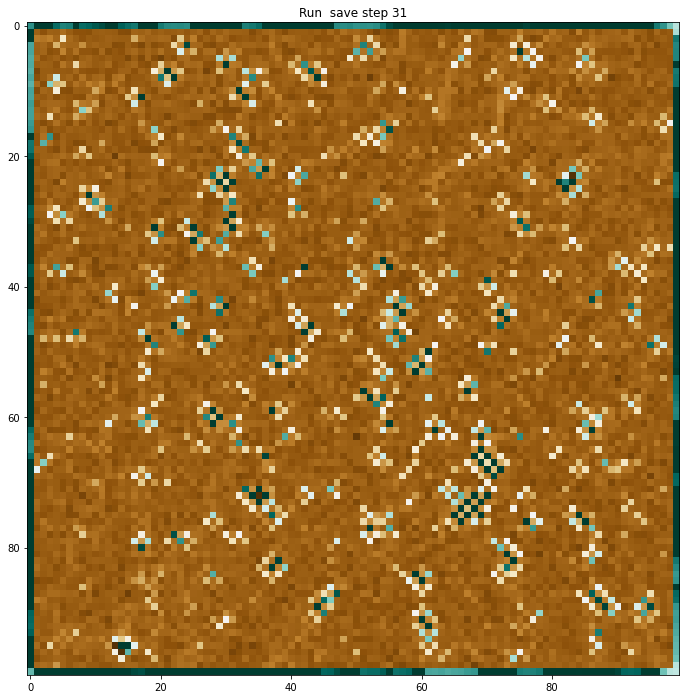

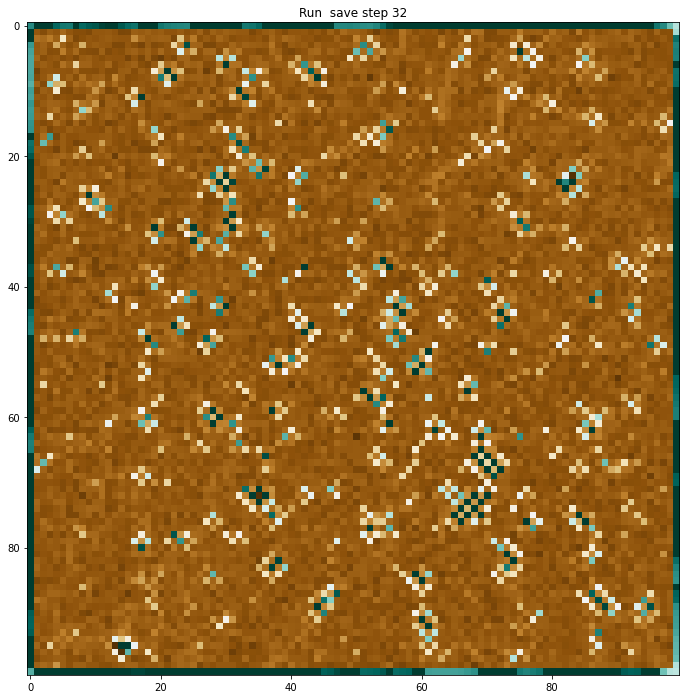

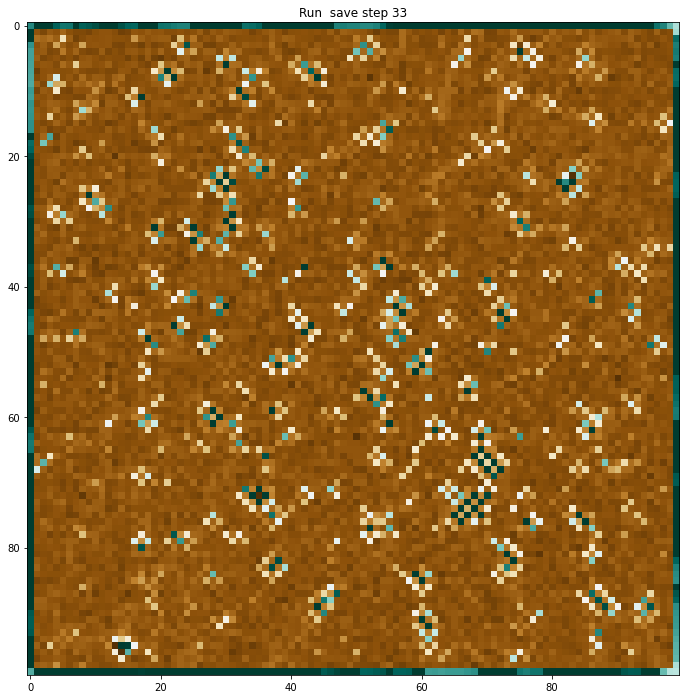

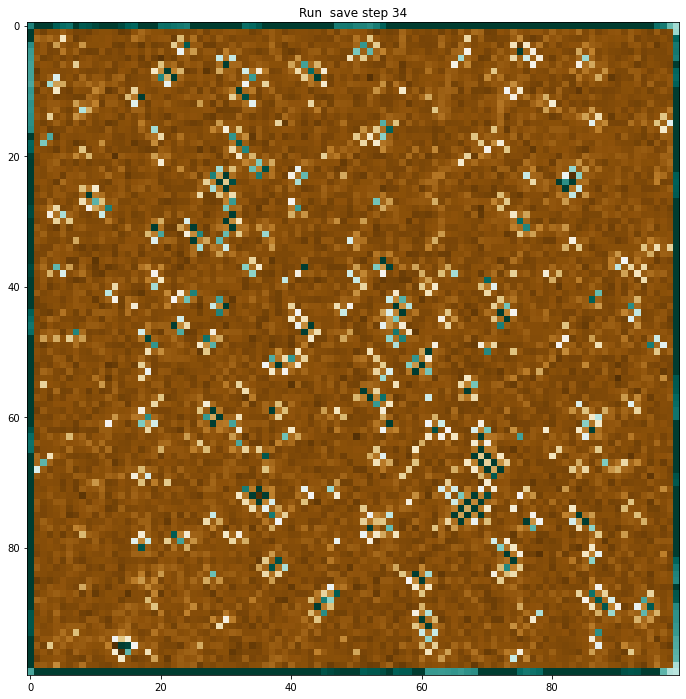

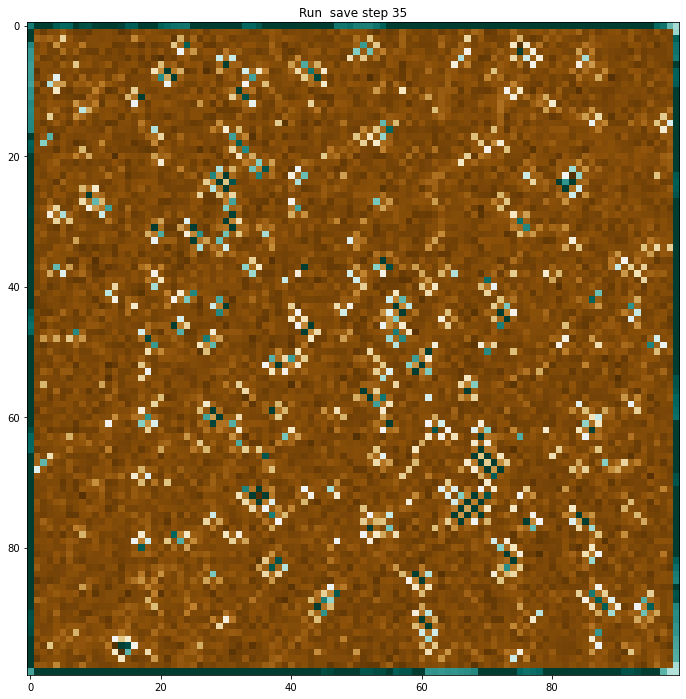

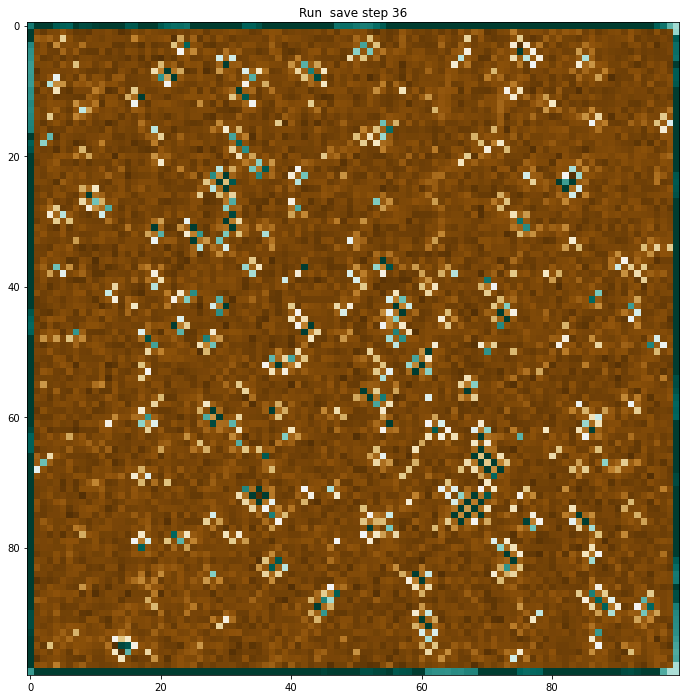

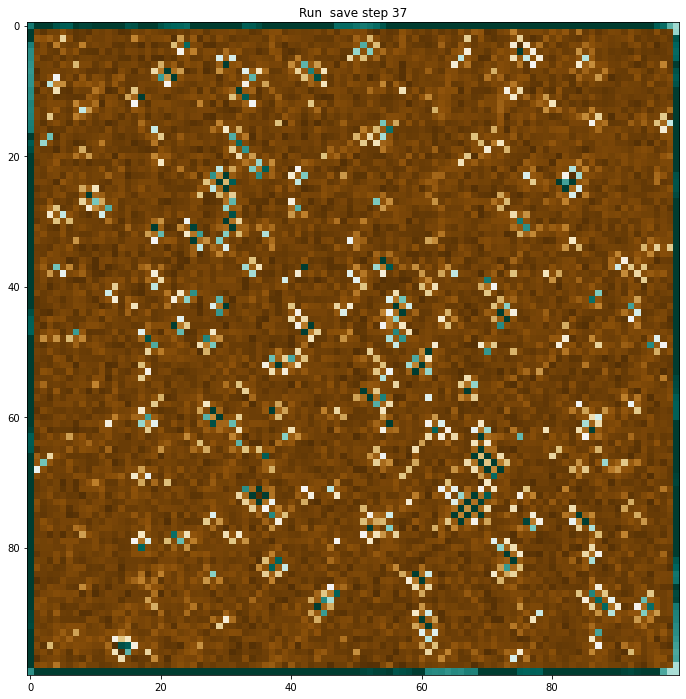

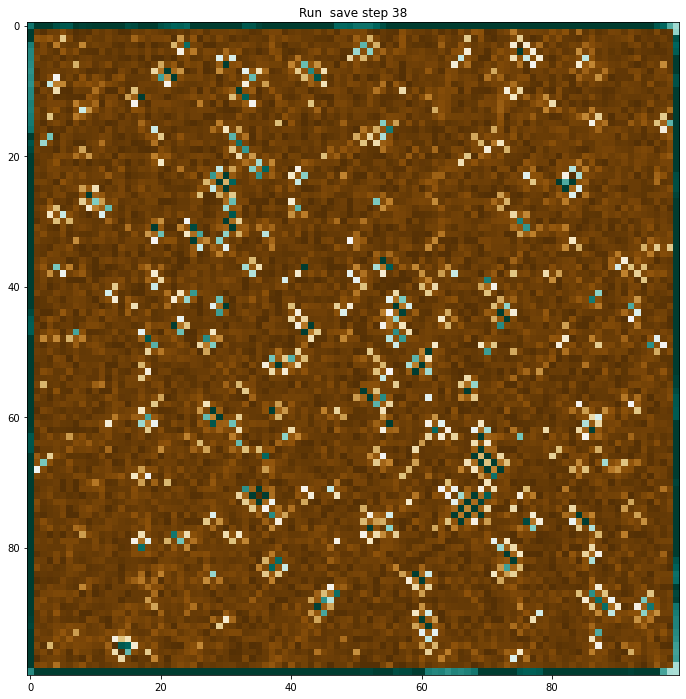

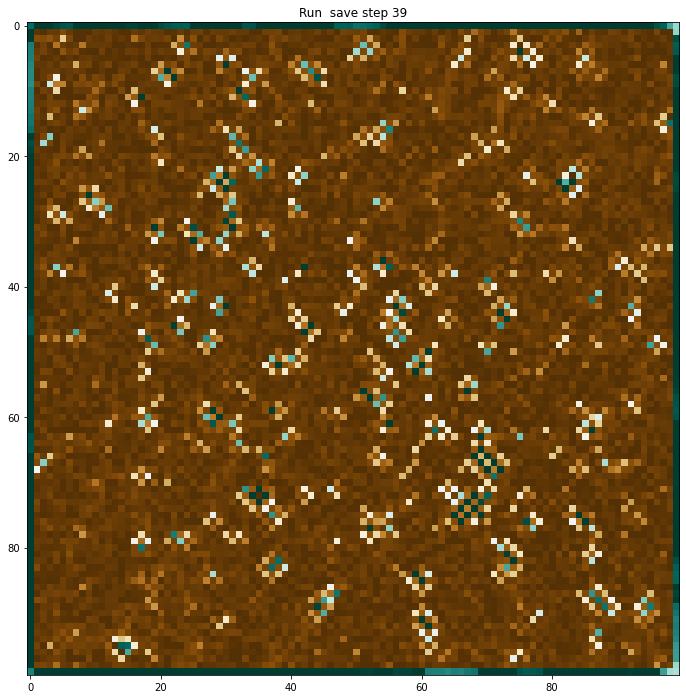

In [23]:
for i in np.arange(40):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    title = "Run  save step " + str(i)
    ax.set_title(title)
    
#     tmp = ndimage.zoom(all_gravel[i] + all_rock[i], 4)
    tmp = all_gravel[i] - all_gravel[0]# + all_rock[i]
    ax.imshow(tmp, cmap=plt.cm.BrBG, vmin=-20, vmax=20)

#         ax.imshow(all_gravel[j][i], cmap=plt.cm.terrain, )
#     tmp = ndimage.zoom(, 4)

#     alphas = all_waters[i] / 20
#     alphas[alphas > 1] = 1
#     ax.imshow(all_waters[i], cmap=plt.cm.Blues, vmin=0, vmax=10, alpha=alphas)

In [14]:
water.sum()

NameError: name 'water' is not defined

In [ ]:
len(zland.flatten())